# Data Science project - OD Travel time Predictor
Students : Alix MEULOT, Anaëlle MARTY, Ghislain MUTABAZI, Nathan DAMBREVILLE

## <u> **I/ Data preprocessing** </u>
###  <u> **0 - Imports** </u>
#### a/ Libraries import

In [46]:
import glob
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import pairwise_distances, r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV, ElasticNetCV
from sklearn import tree

from functions.modelling import *

print("✅ Libraries successfully imported")

✅ Libraries successfully imported


#### b/ `read_whole_pandas_df` function import

In [47]:
alt_path = 'data/VELO-LYON/Trajets VELOV 2019/VELOV_TRAJETS_2019_T2.csv'

from functions.importing import read_whole_pandas_df

print(f"✅ read_whole_pandas_df function imported; alternative_path set as:\n{alt_path}")

✅ read_whole_pandas_df function imported; alternative_path set as:
data/VELO-LYON/Trajets VELOV 2019/VELOV_TRAJETS_2019_T2.csv


#### c/ Velo'v data import

In [48]:
# Data folder's path
BASE_PATH = r"data/"
# Velo'v data's path
LYON_PATH = BASE_PATH + r"VELO-LYON/Trajets VELOV */*.csv"
# Velo'v stations locations file's path
LYON_LOCATIONS = BASE_PATH + r"VELO-LYON/locations/pvo_patrimoine_voirie.pvostationvelov.json"
# Lyon's contours dataset's path
LYON_IRIS = BASE_PATH + r"iris_lyon.shp"
# Coordinates of the center of Lyon
LYON_CENTER = (45.764043, 4.835659)
# Importing the data into a dataframe
df_lyon = read_whole_pandas_df(LYON_PATH, alternative_path=alt_path, sep = ";", enc = "ISO-8859-1", 
                               columns = ["id_exit_station", "exit_station", "date_exit", "id_return_station", "return_station", "date_return"],
                               alternative_dataset=True)
print(f"✅ All datasets were successfully imported")

df_lyon["date_exit"] = pd.to_datetime(df_lyon['date_exit'], format="%Y/%m/%d %H:%M:%S").dt.tz_localize("Europe/Paris", ambiguous="NaT")
df_lyon["date_return"] = pd.to_datetime(df_lyon['date_return'], format="%Y/%m/%d %H:%M:%S").dt.tz_localize("Europe/Paris", ambiguous="NaT")
print(f"✅ The columns |date_exit| and |date_return| were successfully converted to datetime.")
df_lyon.head()

Reading file data/VELO-LYON/Trajets VELOV 2019/VELOV_TRAJETS_2019_T2.csv
✅ All datasets were successfully imported
✅ The columns |date_exit| and |date_return| were successfully converted to datetime.


id_exit_station                         exit_station  \
0             8058             8058 - LONGEFER / KRUGER   
1            10103        10103 - DOUA / RUE DES SPORTS   
2             3003          3003 - PART-DIEU / DERUELLE   
3             6043  6043 - CITÉ INTERNATIONALE / CINÉMA   
4             7033      7033 - SAINT-LUC / SAINT-JOSEPH   

                  date_exit  id_return_station  \
0 2019-04-01 00:00:00+02:00             1022.0   
1 2019-04-01 00:00:00+02:00             6042.0   
2 2019-04-01 00:00:00+02:00             2016.0   
3 2019-04-01 00:00:00+02:00             3005.0   
4 2019-04-01 00:01:00+02:00             7053.0   

                                     return_station               date_return  
0                              1022 - PLACE TOLOZAN 2019-04-01 00:28:00+02:00  
1  6042 - CITÉ INTERNATIONALE / RÉSIDENCE HÔTELIÈRE 2019-04-01 00:07:00+02:00  
2                               2016 - PLACE REGAUD 2019-04-01 00:07:00+02:00  
3                            3005 - SAXE / GAMBETTA 2019-04-01 00:14:00+02:00  
4                       7053 - JAURÈS / THIBAUDIÈRE 2019-04-01 00:05:00+02:00

#### d/ Weather data import
> "Données climatologiques de base - quotidiennes" Meteo-France.
> https://meteo.data.gouv.fr/datasets/6569b51ae64326786e4e8e1a

In [49]:
METEO_PATH = BASE_PATH + r"data-meteo/Q_69_previous-1950-2023_RR-T-Vent.csv"

from functions.importing import read_meteo_data

print(f"✅ read_meteo_data function imported with path:\n{METEO_PATH}")

df_meteo = read_meteo_data(METEO_PATH)
print("✅ The weather dataset was successfully imported")

display(df_meteo.head(5))
df_meteo.shape

✅ read_meteo_data function imported with path:
data/data-meteo/Q_69_previous-1950-2023_RR-T-Vent.csv
Lecture du fichier météo : data/data-meteo/Q_69_previous-1950-2023_RR-T-Vent.csv
✅ The weather dataset was successfully imported


NUM_POSTE        NOM_USUEL        LAT       LON  ALTI  AAAAMMJJ   RR  QRR  \
0   69006001  AMPLEPUIS BOURG  45.971667  4.331667   435  19630301  0.0  1.0   
1   69006001  AMPLEPUIS BOURG  45.971667  4.331667   435  19630302  0.0  1.0   
2   69006001  AMPLEPUIS BOURG  45.971667  4.331667   435  19630303  0.0  1.0   
3   69006001  AMPLEPUIS BOURG  45.971667  4.331667   435  19630304  0.0  1.0   
4   69006001  AMPLEPUIS BOURG  45.971667  4.331667   435  19630305  0.0  1.0   

   TN  QTN  ...  HXI2  QHXI2  FXI3S  QFXI3S  DXI3S  QDXI3S  HXI3S  QHXI3S  \
0 NaN  NaN  ...   NaN    NaN    NaN     NaN    NaN     NaN    NaN     NaN   
1 NaN  NaN  ...   NaN    NaN    NaN     NaN    NaN     NaN    NaN     NaN   
2 NaN  NaN  ...   NaN    NaN    NaN     NaN    NaN     NaN    NaN     NaN   
3 NaN  NaN  ...   NaN    NaN    NaN     NaN    NaN     NaN    NaN     NaN   
4 NaN  NaN  ...   NaN    NaN    NaN     NaN    NaN     NaN    NaN     NaN   

   DRR  QDRR  
0  NaN   NaN  
1  NaN   NaN  
2  NaN   NaN  
3  NaN   NaN  
4  NaN   NaN  

[5 rows x 58 columns]

(1245508, 58)

In this dataset, we have acces to several informations related to the weather conditions. In our model, we will focus on the effect of the wind, the temperature and precipitation. According to the "weather code", the columns below are: 
- RR : precipitation (mm) 
- TN,TX ,TM  : minimal temperature, maximum temperature, mean temparture 
- FF : wind

###  <u> **1 - Adding intermediate columns** </u>
#### a/ Floored datetime column

In [50]:
df_lyon['datetime_1h'] = df_lyon['date_exit'].dt.floor("1H")
df_lyon.head()

C:\Users\ndamb\AppData\Local\Temp\ipykernel_22820\2808807517.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_lyon['datetime_1h'] = df_lyon['date_exit'].dt.floor("1H")


id_exit_station                         exit_station  \
0             8058             8058 - LONGEFER / KRUGER   
1            10103        10103 - DOUA / RUE DES SPORTS   
2             3003          3003 - PART-DIEU / DERUELLE   
3             6043  6043 - CITÉ INTERNATIONALE / CINÉMA   
4             7033      7033 - SAINT-LUC / SAINT-JOSEPH   

                  date_exit  id_return_station  \
0 2019-04-01 00:00:00+02:00             1022.0   
1 2019-04-01 00:00:00+02:00             6042.0   
2 2019-04-01 00:00:00+02:00             2016.0   
3 2019-04-01 00:00:00+02:00             3005.0   
4 2019-04-01 00:01:00+02:00             7053.0   

                                     return_station               date_return  \
0                              1022 - PLACE TOLOZAN 2019-04-01 00:28:00+02:00   
1  6042 - CITÉ INTERNATIONALE / RÉSIDENCE HÔTELIÈRE 2019-04-01 00:07:00+02:00   
2                               2016 - PLACE REGAUD 2019-04-01 00:07:00+02:00   
3                            3005 - SAXE / GAMBETTA 2019-04-01 00:14:00+02:00   
4                       7053 - JAURÈS / THIBAUDIÈRE 2019-04-01 00:05:00+02:00   

                datetime_1h  
0 2019-04-01 00:00:00+02:00  
1 2019-04-01 00:00:00+02:00  
2 2019-04-01 00:00:00+02:00  
3 2019-04-01 00:00:00+02:00  
4 2019-04-01 00:00:00+02:00

#### b/ `day`, `month`, and `travel_time` columns
**NB:** The travel time is computed in minutes.

In [51]:
df_lyon['day'] = df_lyon.date_exit.dt.day_of_week
df_lyon['month'] = df_lyon.date_exit.dt.month
df_lyon['travel_time'] =  (df_lyon.date_return-df_lyon.date_exit).dt.total_seconds()/60
df_lyon.head()

id_exit_station                         exit_station  \
0             8058             8058 - LONGEFER / KRUGER   
1            10103        10103 - DOUA / RUE DES SPORTS   
2             3003          3003 - PART-DIEU / DERUELLE   
3             6043  6043 - CITÉ INTERNATIONALE / CINÉMA   
4             7033      7033 - SAINT-LUC / SAINT-JOSEPH   

                  date_exit  id_return_station  \
0 2019-04-01 00:00:00+02:00             1022.0   
1 2019-04-01 00:00:00+02:00             6042.0   
2 2019-04-01 00:00:00+02:00             2016.0   
3 2019-04-01 00:00:00+02:00             3005.0   
4 2019-04-01 00:01:00+02:00             7053.0   

                                     return_station               date_return  \
0                              1022 - PLACE TOLOZAN 2019-04-01 00:28:00+02:00   
1  6042 - CITÉ INTERNATIONALE / RÉSIDENCE HÔTELIÈRE 2019-04-01 00:07:00+02:00   
2                               2016 - PLACE REGAUD 2019-04-01 00:07:00+02:00   
3                            3005 - SAXE / GAMBETTA 2019-04-01 00:14:00+02:00   
4                       7053 - JAURÈS / THIBAUDIÈRE 2019-04-01 00:05:00+02:00   

                datetime_1h  day  month  travel_time  
0 2019-04-01 00:00:00+02:00    0      4         28.0  
1 2019-04-01 00:00:00+02:00    0      4          7.0  
2 2019-04-01 00:00:00+02:00    0      4          7.0  
3 2019-04-01 00:00:00+02:00    0      4         14.0  
4 2019-04-01 00:00:00+02:00    0      4          4.0

###  <u> **2 - Adding the `distance` column** </u>

In [52]:
gdf_stations = gpd.read_file(LYON_LOCATIONS)
gdf_stations.to_crs('2154', inplace=True)

coords = np.array([[geom.x, geom.y] for geom in gdf_stations.geometry.centroid])
dist_matrix = pairwise_distances(coords, metric="euclidean")
df_dist = pd.DataFrame(dist_matrix, index=gdf_stations['idstation'], columns=gdf_stations['idstation'])
display(df_dist.head())

df_lyon = df_lyon[df_lyon.id_exit_station.isin(df_dist.index) & df_lyon.id_return_station.isin(df_dist.index)].copy()
row_idx = df_dist.index.get_indexer(df_lyon.id_exit_station)
col_idx = df_dist.columns.get_indexer(df_lyon.id_return_station)
df_lyon["distance"] = df_dist.to_numpy()[row_idx, col_idx]
df_lyon.head()

idstation        7024         10063        10021        8038         7045   \
idstation                                                                    
7024          0.000000  3672.322221  4038.271301  2101.306115  1728.531155   
10063      3672.322221     0.000000   367.937601  1918.014222  5276.485492   
10021      4038.271301   367.937601     0.000000  2269.206815  5644.183932   
8038       2101.306115  1918.014222  2269.206815     0.000000  3484.503141   
7045       1728.531155  5276.485492  5644.183932  3484.503141     0.000000   

idstation        6045         8056         8015         7057         7007   \
idstation                                                                    
7024       2359.789599  1897.619990  2771.548411  1581.022503  1739.714329   
10063      2393.483029  3362.975962  2193.760999  4699.773041  5159.729411   
10021      2665.024201  3700.574285  2477.416757  5062.122623  5525.999425   
8038       2327.918947  1467.055847   883.373258  2817.475111  3322.282657   
7045       4061.439765  2522.986998  3875.840707   919.283986   340.362043   

idstation  ...        3035         6039         30002        12005  \
idstation  ...                                                       
7024       ...  1487.311727  2209.079367  8316.839400  7914.027093   
10063      ...  2185.076724  2763.907648  6395.079493  4458.602747   
10021      ...  2550.967781  3042.980467  6250.871362  4115.750370   
8038       ...   940.820395  2518.623358  7840.242909  6376.168575   
7045       ...  3133.747731  3865.225819  9954.924357  9612.529985   

idstation        2027         3040         7017         3138         10049  \
idstation                                                                    
7024       1190.596433  1448.733485  1397.488839  1707.214746  4936.861621   
10063      4860.315824  2233.220170  4667.580451  2109.599779  1478.056510   
10021      5225.466883  2596.741636  5032.708705  2457.739820  1175.815415   
8038       3252.453650  1066.873708  2814.886550  1368.271058  3379.142600   
7045        932.679947  3123.005262   758.389211  3425.591997  6614.809720   

idstation        10044  
idstation               
7024       5241.842046  
10063      2520.604551  
10021      2354.611591  
8038       4169.994273  
7045       6970.331063  

[5 rows x 431 columns]

id_exit_station                         exit_station  \
0             8058             8058 - LONGEFER / KRUGER   
1            10103        10103 - DOUA / RUE DES SPORTS   
2             3003          3003 - PART-DIEU / DERUELLE   
3             6043  6043 - CITÉ INTERNATIONALE / CINÉMA   
4             7033      7033 - SAINT-LUC / SAINT-JOSEPH   

                  date_exit  id_return_station  \
0 2019-04-01 00:00:00+02:00             1022.0   
1 2019-04-01 00:00:00+02:00             6042.0   
2 2019-04-01 00:00:00+02:00             2016.0   
3 2019-04-01 00:00:00+02:00             3005.0   
4 2019-04-01 00:01:00+02:00             7053.0   

                                     return_station               date_return  \
0                              1022 - PLACE TOLOZAN 2019-04-01 00:28:00+02:00   
1  6042 - CITÉ INTERNATIONALE / RÉSIDENCE HÔTELIÈRE 2019-04-01 00:07:00+02:00   
2                               2016 - PLACE REGAUD 2019-04-01 00:07:00+02:00   
3                            3005 - SAXE / GAMBETTA 2019-04-01 00:14:00+02:00   
4                       7053 - JAURÈS / THIBAUDIÈRE 2019-04-01 00:05:00+02:00   

                datetime_1h  day  month  travel_time     distance  
0 2019-04-01 00:00:00+02:00    0      4         28.0  4659.845582  
1 2019-04-01 00:00:00+02:00    0      4          7.0  1629.727220  
2 2019-04-01 00:00:00+02:00    0      4          7.0  1610.518885  
3 2019-04-01 00:00:00+02:00    0      4         14.0  3446.325685  
4 2019-04-01 00:00:00+02:00    0      4          4.0   807.072642

###  <u> **3 - Filtering** </u>
#### i/ Filtering the Velo'v data based on speed

In [53]:
# Creating a `speed` column based on the travel time and the distance (values in km/h for future readability)
df_lyon["speed"] = (df_lyon["distance"]/1000) / (df_lyon["travel_time"]/60)
# Filtering the data where the speed is below 5 km/h or above 30 km/h
df_lyon = df_lyon[df_lyon.speed.between(5,30)]
# Filtering the travels where the exit station and the return station are identical
df_lyon = df_lyon[df_lyon.id_exit_station != df_lyon.id_return_station]

print("There are ", df_lyon.shape[0], "travels after filtering.")
df_lyon.sample(10)

There are  1840292 travels after filtering.


id_exit_station                    exit_station  \
581947              8015               8015 - JEAN XXIII   
136558             10021            10021 - GRANDCLÉMENT   
1686959             7034         7034 - PISCINE DU RHÔNE   
735794             10005             10005 - 11 NOVEMBRE   
260944              7018        7018 - LYCEE LOUISE LABE   
1989824             3088           3088 - PLACE GUICHARD   
905790              3005          3005 - SAXE / GAMBETTA   
1933908             3029    3029 - PLACE ARISTIDE BRIAND   
1737572            10006              10006 - CHARPENNES   
1816420             3011  3011 - PART-DIEU / CUIRASSIERS   

                        date_exit  id_return_station  \
581947  2019-04-24 08:29:00+02:00            10056.0   
136558  2019-04-05 23:53:00+02:00             6040.0   
1686959 2019-06-08 11:30:00+02:00             3088.0   
735794  2019-05-01 12:04:00+02:00            10080.0   
260944  2019-04-10 18:10:00+02:00             7009.0   
1989824 2019-06-23 14:43:00+02:00             6036.0   
905790  2019-05-07 20:05:00+02:00             7009.0   
1933908 2019-06-20 20:42:00+02:00             1032.0   
1737572 2019-06-12 08:12:00+02:00             2020.0   
1816420 2019-06-15 19:26:00+02:00             3037.0   

                              return_station               date_return  \
581947   10056 - 11 NOVEMBRE / GASTON BERGER 2019-04-24 08:48:00+02:00   
136558                     6040 - LES HALLES 2019-04-06 00:06:00+02:00   
1686959                3088 - PLACE GUICHARD 2019-06-08 11:36:00+02:00   
735794          10080 - VAILLANT / PERRONCEL 2019-05-01 12:15:00+02:00   
260944                    7009 - JEAN JAURÈS 2019-04-10 18:13:00+02:00   
1989824      6036 - MUSÉE D'ART CONTEMPORAIN 2019-06-23 15:02:00+02:00   
905790                    7009 - JEAN JAURÈS 2019-05-07 20:15:00+02:00   
1933908                         1032 - PIZAY 2019-06-20 20:53:00+02:00   
1737572         2020 - MUSÉE DES CONFLUENCES 2019-06-12 08:32:00+02:00   
1816420         3037 - PAUL BERT / GARIBALDI 2019-06-15 19:31:00+02:00   

                      datetime_1h  day  month  travel_time     distance  \
581947  2019-04-24 08:00:00+02:00    2      4         19.0  4307.001733   
136558  2019-04-05 23:00:00+02:00    4      4         13.0  3147.493680   
1686959 2019-06-08 11:00:00+02:00    5      6          6.0   862.303211   
735794  2019-05-01 12:00:00+02:00    2      5         11.0  1644.572461   
260944  2019-04-10 18:00:00+02:00    2      4          3.0   523.151381   
1989824 2019-06-23 14:00:00+02:00    6      6         19.0  2818.513258   
905790  2019-05-07 20:00:00+02:00    1      5         10.0  1983.523337   
1933908 2019-06-20 20:00:00+02:00    3      6         11.0  1909.255813   
1737572 2019-06-12 08:00:00+02:00    2      6         20.0  5343.483093   
1816420 2019-06-15 19:00:00+02:00    5      6          5.0   444.424874   

             speed  
581947   13.601058  
136558   14.526894  
1686959   8.623032  
735794    8.970395  
260944   10.463028  
1989824   8.900568  
905790   11.901140  
1933908  10.414123  
1737572  16.030449  
1816420   5.333098

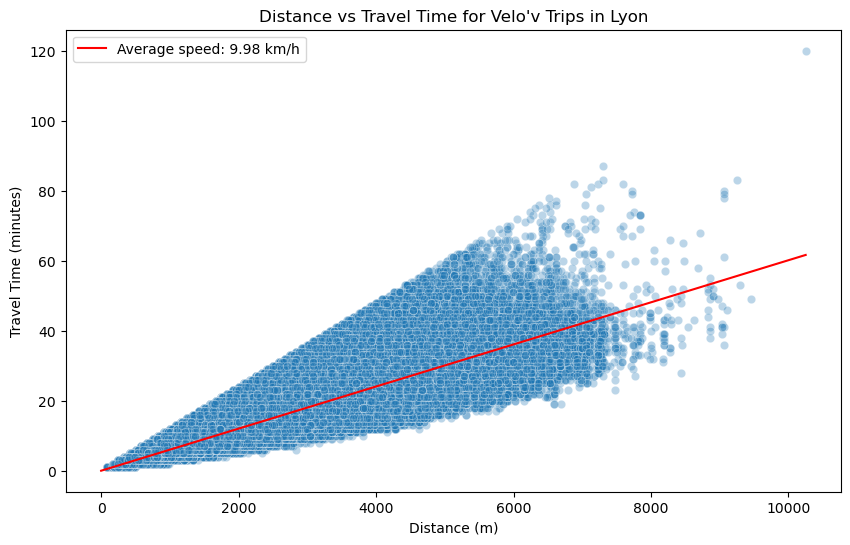

In [54]:
# Plotting a scatter graph of the distance vs travel time with a red line representing the average speed of the dataset
avg_speed = df_lyon["speed"].mean()
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_lyon, x="distance", y="travel_time", alpha=0.3)
x = np.linspace(0, df_lyon["distance"].max(), 100)
plt.plot(x, (x/1000)/(avg_speed/60), color='red', label=f'Average speed: {avg_speed:.2f} km/h')
plt.xlabel("Distance (m)")
plt.ylabel("Travel Time (minutes)")
plt.title("Distance vs Travel Time for Velo'v Trips in Lyon")
plt.legend()
plt.show()

#### ii/ Time filtering the weather data
We will merge the weather dataset with the  velo-lyon dataset. We have to work on the same period, so we clean our weather dataset. The period selected is between the 01/01/2019 and the 22/04/2021

In [55]:
# Date conversion
df_meteo['date'] = pd.to_datetime(df_meteo['AAAAMMJJ'].astype(str), format='%Y%m%d')

# Filter data between 2019-01-01 and 2021-04-22
start_date = pd.to_datetime("2019-01-01")
end_date = pd.to_datetime("2021-04-22")

df_meteo = df_meteo[(df_meteo['date'] >= start_date) & (df_meteo['date'] <= end_date)]
df_meteo.head()

NUM_POSTE NOM_USUEL        LAT       LON  ALTI  AAAAMMJJ   RR  QRR  TN  \
23102   69007001    AMPUIS  45.490667  4.811167   157  20190101  0.0  1.0 NaN   
23103   69007001    AMPUIS  45.490667  4.811167   157  20190102  0.0  1.0 NaN   
23104   69007001    AMPUIS  45.490667  4.811167   157  20190103  0.0  1.0 NaN   
23105   69007001    AMPUIS  45.490667  4.811167   157  20190104  0.0  1.0 NaN   
23106   69007001    AMPUIS  45.490667  4.811167   157  20190105  0.0  1.0 NaN   

       QTN  ...  QHXI2  FXI3S  QFXI3S  DXI3S  QDXI3S  HXI3S  QHXI3S  DRR  \
23102  NaN  ...    NaN    NaN     NaN    NaN     NaN    NaN     NaN  NaN   
23103  NaN  ...    NaN    NaN     NaN    NaN     NaN    NaN     NaN  NaN   
23104  NaN  ...    NaN    NaN     NaN    NaN     NaN    NaN     NaN  NaN   
23105  NaN  ...    NaN    NaN     NaN    NaN     NaN    NaN     NaN  NaN   
23106  NaN  ...    NaN    NaN     NaN    NaN     NaN    NaN     NaN  NaN   

       QDRR       date  
23102   NaN 2019-01-01  
23103   NaN 2019-01-02  
23104   NaN 2019-01-03  
23105   NaN 2019-01-04  
23106   NaN 2019-01-05  

[5 rows x 59 columns]

In [56]:
#Convert AAAAMMJJ to datetime
df_meteo["AAAAMMJJ"] = df_meteo["AAAAMMJJ"].astype(int).astype(str)
df_meteo["datetime_day"] = pd.to_datetime(df_meteo["AAAAMMJJ"], format="%Y%m%d").dt.date

# Verify the conversion
print(df_meteo[["AAAAMMJJ", "datetime_day"]].head())

       AAAAMMJJ datetime_day
23102  20190101   2019-01-01
23103  20190102   2019-01-02
23104  20190103   2019-01-03
23105  20190104   2019-01-04
23106  20190105   2019-01-05


#### iii/ Filtering the weather data to 1 station

In [57]:
#Display columns of the dataframe
df_meteo.columns

Index(['NUM_POSTE', 'NOM_USUEL', 'LAT', 'LON', 'ALTI', 'AAAAMMJJ', 'RR', 'QRR',
       'TN', 'QTN', 'HTN', 'QHTN', 'TX', 'QTX', 'HTX', 'QHTX', 'TM', 'QTM',
       'TNTXM', 'QTNTXM', 'TAMPLI', 'QTAMPLI', 'TNSOL', 'QTNSOL', 'TN50',
       'QTN50', 'DG', 'QDG', 'FFM', 'QFFM', 'FF2M', 'QFF2M', 'FXY', 'QFXY',
       'DXY', 'QDXY', 'HXY', 'QHXY', 'FXI', 'QFXI', 'DXI', 'QDXI', 'HXI',
       'QHXI', 'FXI2', 'QFXI2', 'DXI2', 'QDXI2', 'HXI2', 'QHXI2', 'FXI3S',
       'QFXI3S', 'DXI3S', 'QDXI3S', 'HXI3S', 'QHXI3S', 'DRR', 'QDRR', 'date',
       'datetime_day'],
      dtype='object')

In [58]:
#Display the meteo station names
df_meteo['NOM_USUEL'].unique()


array(['AMPUIS', 'ANCY_SAPC', 'LE BREUIL', 'BRINDAS', 'LYON-BRON',
       'CALUIRE4', 'CERCIE EN BEAUJOLAIS', 'CONDRIEU',
       'COURS LA VILLE_SAPC', 'LES HAIES', 'JULLIE', 'LAMURE-SUR-AZER',
       'LANCIE', 'LIERGUES_SAPC', "LYON TETE D'OR", 'LYON-FOURVIERE',
       'MONSOLS', 'MONTROTTIER', 'MORNANT', 'POMMIERS', 'PONT TRAMBOUZE',
       'AZOLETTE', 'LES SAUVAGES', 'ST-CYR-CHATOUX', 'ST-DIDIER-RIVER',
       'ST-DIDIER-BEAUJ', "ST-GENIS-L'ARGENTIERE", 'ST-GENIS-LAVAL',
       'ST-GEORGES-REN', 'ST-GERMAIN-L AR', 'POPEY', 'ST-SYMPHORIEN-C',
       'SAINT-VERAND', 'TRADES', 'VAUX-EN-BEAUJOL', 'VAUXRENARD',
       'VILLEFRANCHE', 'CORBAS', 'RILLIEUX', 'LYON-ST EXUPERY'],
      dtype=object)

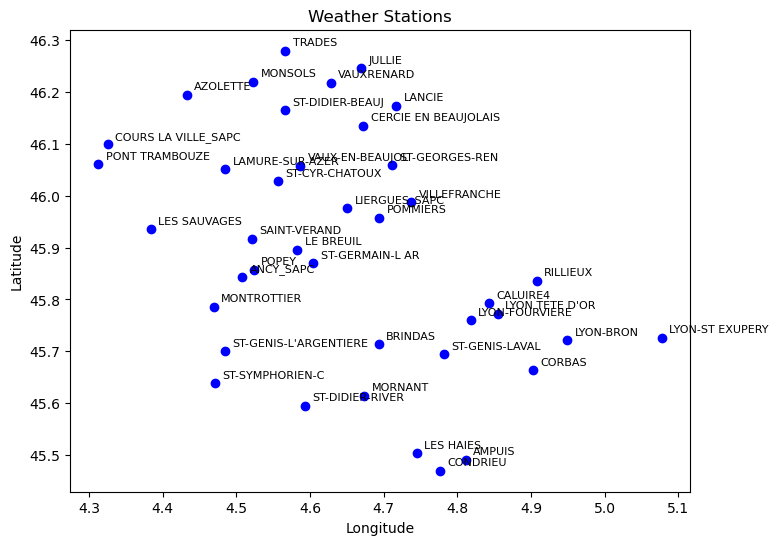

In [59]:
import matplotlib.pyplot as plt

# Remove duplicates to keep only one row per station
stations = df_meteo[['NOM_USUEL','LAT','LON']].drop_duplicates()

plt.figure(figsize=(8,6))
plt.scatter(stations['LON'], stations['LAT'], color='blue')

# Add station names
for i, row in stations.iterrows():
    plt.text(row['LON'] + 0.01, row['LAT'] + 0.01, row['NOM_USUEL'], fontsize=8)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Weather Stations")
plt.show()





In [60]:
# Example: coordinates of Lyon center (from previous cell)
center = LYON_CENTER

# Keep one row per station
stations = df_meteo[['NOM_USUEL', 'LAT', 'LON']].drop_duplicates()

# Haversine function to compute distance in km
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    
    a = np.sin(dphi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return R * c

# Compute distance from each station to Lyon center
stations['distance_to_lyon_km'] = stations.apply(
    lambda row: haversine(row['LAT'], row['LON'], center[0], center[1]),
    axis=1
)

# Sort by distance
stations = stations.sort_values('distance_to_lyon_km')

# Show the 5 closest stations
print(stations[['NOM_USUEL', 'LAT', 'LON', 'distance_to_lyon_km']].head())


              NOM_USUEL        LAT       LON  distance_to_lyon_km
507643   LYON-FOURVIERE  45.759667  4.818167             1.441536
470489   LYON TETE D'OR  45.772833  4.855167             1.801364
179616         CALUIRE4  45.792833  4.843500             3.258542
817072   ST-GENIS-LAVAL  45.694667  4.782333             8.754554
1226989        RILLIEUX  45.835500  4.907833             9.717916


In [61]:
# List of wind columns (and precipitation)
vent_cols = ['FFM','FF2M','FXI','FXI2','FXI3S',"RR"]

# Check availability per station
vent_dispo = df_meteo.groupby('NOM_USUEL')[vent_cols].apply(lambda x: x.notna().sum())

# Display stations and the number of available values, sorted by FFM descending
print(vent_dispo.sort_values(by='FFM', ascending=False))


                       FFM  FF2M  FXI  FXI2  FXI3S   RR
NOM_USUEL                                              
ST-GEORGES-REN         843     0  843     0    516  843
LYON-ST EXUPERY        843     0  842     0    724  843
LYON-BRON              842     0  841     0    836  843
VAUXRENARD             838     0  838     0    486  843
LES SAUVAGES           818     0  821     0    490  843
BRINDAS                817     0  818     0    492  843
ANCY_SAPC                0     0    0     0      0  843
AMPUIS                   0     0    0     0      0  700
CORBAS                   0     0    0     0      0  365
CONDRIEU                 0     0    0     0      0  731
CERCIE EN BEAUJOLAIS     0     0    0     0      0  731
CALUIRE4                 0     0    0     0      0  700
AZOLETTE                 0     0    0     0      0  304
LE BREUIL                0     0    0     0      0  843
LANCIE                   0     0    0     0      0  700
COURS LA VILLE_SAPC      0     0    0     0     

We keep the meteo information of the station Lyon - Bron because it is the closest station from the center of Lyon that measures, the temperature the wind and the precipitation. 

In [62]:
# Filter on the station "LYON-BRON"
meteo_bron = df_meteo[df_meteo['NOM_USUEL'] == "LYON-BRON"].copy()

# Verify the result 
print(meteo_bron[['NOM_USUEL', 'LAT', 'LON']].drop_duplicates())
print(meteo_bron.head())


        NOM_USUEL        LAT       LON
109675  LYON-BRON  45.721333  4.949167
        NUM_POSTE  NOM_USUEL        LAT       LON  ALTI  AAAAMMJJ   RR  QRR  \
109675   69029001  LYON-BRON  45.721333  4.949167   202  20190101  0.0  1.0   
109676   69029001  LYON-BRON  45.721333  4.949167   202  20190102  0.0  1.0   
109677   69029001  LYON-BRON  45.721333  4.949167   202  20190103  0.0  1.0   
109678   69029001  LYON-BRON  45.721333  4.949167   202  20190104  0.0  1.0   
109679   69029001  LYON-BRON  45.721333  4.949167   202  20190105  0.0  1.0   

         TN  QTN  ...  FXI3S  QFXI3S  DXI3S  QDXI3S   HXI3S  QHXI3S  DRR  \
109675  6.5  1.0  ...    8.6     1.0    NaN     NaN  1738.0     9.0  0.0   
109676  4.0  1.0  ...   14.3     1.0    NaN     NaN  1410.0     9.0  0.0   
109677 -0.1  1.0  ...   12.6     1.0    NaN     NaN  1425.0     9.0  0.0   
109678 -0.2  1.0  ...   10.6     1.0    NaN     NaN  1319.0     9.0  0.0   
109679  1.2  1.0  ...   10.9     1.0    NaN     NaN   117.0     9.0

###  <u> **4 - Converting the weather data into usable data for modelling** </u>


In [63]:
# Create average temperature if TM is not reliable
meteo_bron['T_moy'] = meteo_bron[['TN','TX']].mean(axis=1)

# Convert wind (mean wind FFM) to km/h
meteo_bron['vent_kmh'] = meteo_bron['FFM'] * 3.6

# Create a daily aggregated DataFrame
meteo_jour = meteo_bron.groupby('AAAAMMJJ').agg({
    'T_moy': 'mean',        # daily average temperature
    'RR': 'sum',            # total daily precipitation
    'vent_kmh': 'mean'      # daily average wind speed (km/h)
}).reset_index()

# Show the first rows
display(meteo_jour.head())
meteo_jour.shape


AAAAMMJJ  T_moy   RR  vent_kmh
0  20190101   6.90  0.0     13.32
1  20190102   5.45  0.0     21.96
2  20190103   2.45  0.0     20.52
3  20190104   2.75  0.0     18.00
4  20190105   2.75  0.0     19.08

(843, 4)

In [64]:
#We create the temperature categories

conditions_temp = [
    (meteo_jour["T_moy"] < 0), 
    (meteo_jour["T_moy"] >= 0) & (meteo_jour["T_moy"] < 10),
    (meteo_jour["T_moy"] >= 10) & (meteo_jour["T_moy"] < 20),
    (meteo_jour["T_moy"] >= 20)
]
categories_temp = ["cold", "cool", "warm", "very_warm"]
meteo_jour["temp_category"] = np.select(conditions_temp, categories_temp, default="unknown")

#We create the rainfall categories

conditions_RR = [
    (meteo_jour["RR"] == 0),
    (meteo_jour["RR"] > 0) & (meteo_jour["RR"] <= 2),
    (meteo_jour["RR"] > 2) & (meteo_jour["RR"] <= 10),
    (meteo_jour["RR"] > 10)
]

categories_RR = ["none", "light", "moderate", "heavy"]

meteo_jour["rain_category"] = np.select(conditions_RR, categories_RR, default="none")

#We create the wind categories  

conditions_wind = [
    (meteo_jour["vent_kmh"] < 10),
    (meteo_jour["vent_kmh"] >= 10) & (meteo_jour["vent_kmh"] < 20),
    (meteo_jour["vent_kmh"] >= 20) & (meteo_jour["vent_kmh"] < 40),
    (meteo_jour["vent_kmh"] >= 40)
]   
categories_wind = ["calm", "light", "windy", "stormy"]
meteo_jour["wind_category"] = np.select(conditions_wind, categories_wind, default="unknown")

meteo_jour

AAAAMMJJ  T_moy   RR  vent_kmh temp_category rain_category wind_category
0    20190101   6.90  0.0     13.32          cool          none         light
1    20190102   5.45  0.0     21.96          cool          none         windy
2    20190103   2.45  0.0     20.52          cool          none         windy
3    20190104   2.75  0.0     18.00          cool          none         light
4    20190105   2.75  0.0     19.08          cool          none         light
..        ...    ...  ...       ...           ...           ...           ...
838  20210418   9.25  0.0     15.48          cool          none         light
839  20210419  10.25  0.0     10.44          warm          none         light
840  20210420  11.15  0.2      7.20          warm         light          calm
841  20210421  12.80  0.2      7.92          warm         light          calm
842  20210422  13.85  0.0      9.00          warm          none          calm

[843 rows x 7 columns]

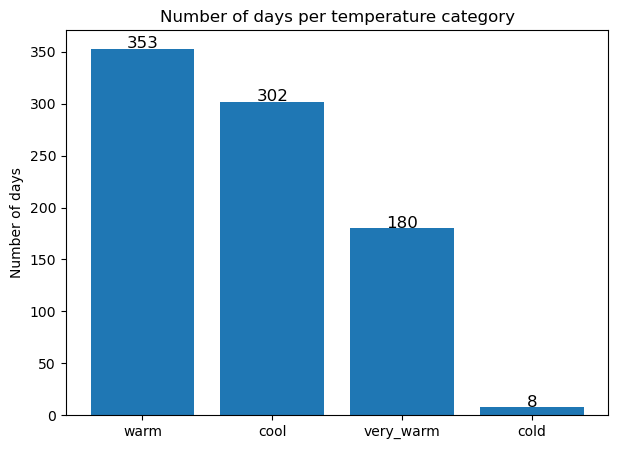

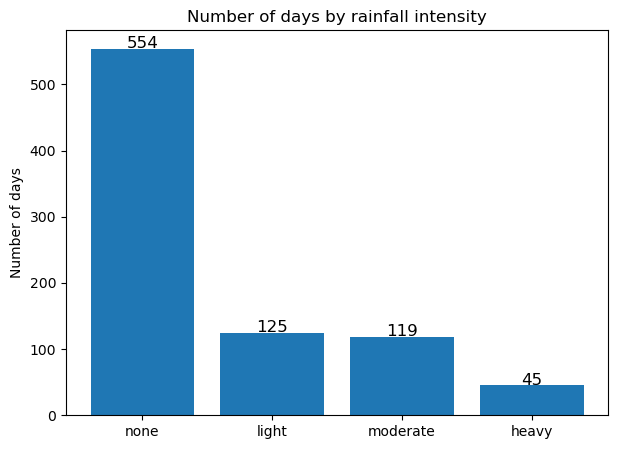

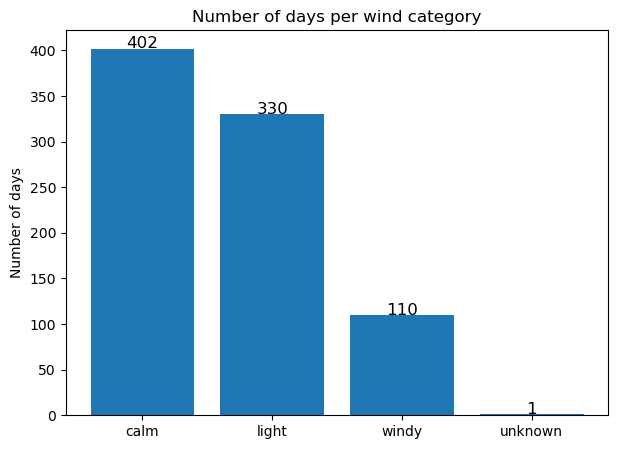

In [65]:

# Plot for temperature categories
plt.figure(figsize=(7,5))
temp_counts = meteo_jour["temp_category"].value_counts()

plt.bar(temp_counts.index, temp_counts.values)
plt.ylabel("Number of days")
plt.title("Number of days per temperature category")

for i, v in enumerate(temp_counts.values):
    plt.text(i, v + 0.5, str(v), ha='center', fontsize=12)

plt.show()

# Plot for rain categories
plt.figure(figsize=(7,5))
rain_counts = meteo_jour["rain_category"].value_counts()

plt.bar(rain_counts.index, rain_counts.values)
plt.ylabel("Number of days")
plt.title("Number of days by rainfall intensity")

for i, v in enumerate(rain_counts.values):
    plt.text(i, v + 0.5, str(v), ha='center', fontsize=12)

plt.show()

# Plot for wind categories
plt.figure(figsize=(7,5))
wind_counts = meteo_jour["wind_category"].value_counts()

plt.bar(wind_counts.index, wind_counts.values)
plt.ylabel("Number of days")
plt.title("Number of days per wind category")

for i, v in enumerate(wind_counts.values):
    plt.text(i, v + 0.5, str(v), ha='center', fontsize=12)

plt.show()




Note : I don't know why there is an unkwon category 

In [66]:
# Convert to string
meteo_jour["AAAAMMJJ"] = meteo_jour["AAAAMMJJ"].astype(int).astype(str)

# Convert to datetime
meteo_jour["datetime_day"] = pd.to_datetime(meteo_jour["AAAAMMJJ"], format="%Y%m%d").dt.date

# Verify
print(meteo_jour)


     AAAAMMJJ  T_moy   RR  vent_kmh temp_category rain_category wind_category  \
0    20190101   6.90  0.0     13.32          cool          none         light   
1    20190102   5.45  0.0     21.96          cool          none         windy   
2    20190103   2.45  0.0     20.52          cool          none         windy   
3    20190104   2.75  0.0     18.00          cool          none         light   
4    20190105   2.75  0.0     19.08          cool          none         light   
..        ...    ...  ...       ...           ...           ...           ...   
838  20210418   9.25  0.0     15.48          cool          none         light   
839  20210419  10.25  0.0     10.44          warm          none         light   
840  20210420  11.15  0.2      7.20          warm         light          calm   
841  20210421  12.80  0.2      7.92          warm         light          calm   
842  20210422  13.85  0.0      9.00          warm          none          calm   

    datetime_day  
0     20

In [67]:
df_lyon["datetime_day"] = pd.to_datetime(df_lyon["datetime_1h"], format="%Y%m%d").dt.date
df_lyon.head()

id_exit_station                         exit_station  \
0             8058             8058 - LONGEFER / KRUGER   
1            10103        10103 - DOUA / RUE DES SPORTS   
2             3003          3003 - PART-DIEU / DERUELLE   
3             6043  6043 - CITÉ INTERNATIONALE / CINÉMA   
4             7033      7033 - SAINT-LUC / SAINT-JOSEPH   

                  date_exit  id_return_station  \
0 2019-04-01 00:00:00+02:00             1022.0   
1 2019-04-01 00:00:00+02:00             6042.0   
2 2019-04-01 00:00:00+02:00             2016.0   
3 2019-04-01 00:00:00+02:00             3005.0   
4 2019-04-01 00:01:00+02:00             7053.0   

                                     return_station               date_return  \
0                              1022 - PLACE TOLOZAN 2019-04-01 00:28:00+02:00   
1  6042 - CITÉ INTERNATIONALE / RÉSIDENCE HÔTELIÈRE 2019-04-01 00:07:00+02:00   
2                               2016 - PLACE REGAUD 2019-04-01 00:07:00+02:00   
3                            3005 - SAXE / GAMBETTA 2019-04-01 00:14:00+02:00   
4                       7053 - JAURÈS / THIBAUDIÈRE 2019-04-01 00:05:00+02:00   

                datetime_1h  day  month  travel_time     distance      speed  \
0 2019-04-01 00:00:00+02:00    0      4         28.0  4659.845582   9.985383   
1 2019-04-01 00:00:00+02:00    0      4          7.0  1629.727220  13.969090   
2 2019-04-01 00:00:00+02:00    0      4          7.0  1610.518885  13.804448   
3 2019-04-01 00:00:00+02:00    0      4         14.0  3446.325685  14.769967   
4 2019-04-01 00:00:00+02:00    0      4          4.0   807.072642  12.106090   

  datetime_day  
0   2019-04-01  
1   2019-04-01  
2   2019-04-01  
3   2019-04-01  
4   2019-04-01

In [68]:
df_meteo = df_lyon.merge(meteo_jour, on="datetime_day", how="left")
df_meteo

id_exit_station                         exit_station  \
0                   8058             8058 - LONGEFER / KRUGER   
1                  10103        10103 - DOUA / RUE DES SPORTS   
2                   3003          3003 - PART-DIEU / DERUELLE   
3                   6043  6043 - CITÉ INTERNATIONALE / CINÉMA   
4                   7033      7033 - SAINT-LUC / SAINT-JOSEPH   
...                  ...                                  ...   
1840287             7055            7055 - SERVANT / JABOULAY   
1840288             7024             7024 - BANCEL / CHEVREUL   
1840289            10087                      10087 - BARATIN   
1840290             2026         2026 - RÉPUBLIQUE / PAUFIQUE   
1840291             3084                        3084 - DESAIX   

                        date_exit  id_return_station  \
0       2019-04-01 00:00:00+02:00             1022.0   
1       2019-04-01 00:00:00+02:00             6042.0   
2       2019-04-01 00:00:00+02:00             2016.0   
3       2019-04-01 00:00:00+02:00             3005.0   
4       2019-04-01 00:01:00+02:00             7053.0   
...                           ...                ...   
1840287 2019-06-30 23:59:00+02:00             8051.0   
1840288 2019-06-30 23:59:00+02:00             2012.0   
1840289 2019-06-30 23:59:00+02:00            10074.0   
1840290 2019-06-30 23:59:00+02:00            10011.0   
1840291 2019-06-30 23:59:00+02:00             7023.0   

                                           return_station  \
0                                    1022 - PLACE TOLOZAN   
1        6042 - CITÉ INTERNATIONALE / RÉSIDENCE HÔTELIÈRE   
2                                     2016 - PLACE REGAUD   
3                                  3005 - SAXE / GAMBETTA   
4                             7053 - JAURÈS / THIBAUDIÈRE   
...                                                   ...   
1840287                 8051 - HÔPITAL SAINT-JEAN DE DIEU   
1840288                                  2012 - GAILLETON   
1840289                        10074 - ZOLA / PASSAGE REY   
1840290                               10011 - GRATTE-CIEL   
1840291                7023 - BERTHELOT / ROUTE DE VIENNE   

                      date_return               datetime_1h  day  month  \
0       2019-04-01 00:28:00+02:00 2019-04-01 00:00:00+02:00    0      4   
1       2019-04-01 00:07:00+02:00 2019-04-01 00:00:00+02:00    0      4   
2       2019-04-01 00:07:00+02:00 2019-04-01 00:00:00+02:00    0      4   
3       2019-04-01 00:14:00+02:00 2019-04-01 00:00:00+02:00    0      4   
4       2019-04-01 00:05:00+02:00 2019-04-01 00:00:00+02:00    0      4   
...                           ...                       ...  ...    ...   
1840287 2019-07-01 00:12:00+02:00 2019-06-30 23:00:00+02:00    6      6   
1840288 2019-07-01 00:05:00+02:00 2019-06-30 23:00:00+02:00    6      6   
1840289 2019-07-01 00:23:00+02:00 2019-06-30 23:00:00+02:00    6      6   
1840290 2019-07-01 00:14:00+02:00 2019-06-30 23:00:00+02:00    6      6   
1840291 2019-07-01 00:09:00+02:00 2019-06-30 23:00:00+02:00    6      6   

         travel_time     distance      speed datetime_day  AAAAMMJJ  T_moy  \
0               28.0  4659.845582   9.985383   2019-04-01  20190401  13.35   
1                7.0  1629.727220  13.969090   2019-04-01  20190401  13.35   
2                7.0  1610.518885  13.804448   2019-04-01  20190401  13.35   
3               14.0  3446.325685  14.769967   2019-04-01  20190401  13.35   
4                4.0   807.072642  12.106090   2019-04-01  20190401  13.35   
...              ...          ...        ...          ...       ...    ...   
1840287         13.0  2683.562667  12.385674   2019-06-30  20190630  30.85   
1840288          6.0   780.698976   7.806990   2019-06-30  20190630  30.85   
1840289         24.0  2143.386270   5.358466   2019-06-30  20190630  30.85   
1840290         15.0  3669.217483  14.676870   2019-06-30  20190630  30.85   
1840291         10.0  1669.803364  10.018820   2019-06-30  2019

## <u> **II/ Regression modelling** </u>
###  <u> **1 - Simple linear regression** </u>
#### a/ Model 0 definition

In [69]:
# STEP 1 - EXTRACTING THE RELEVANT COLUMNS
y = df_lyon['travel_time']
X = df_lyon[['distance']]

# STEP 2 - SPLITTING THE DATA INTO TRAINING AND TEST SETS
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# STEP 3 - CREATING AND TRAINING THE MODEL
model = LinearRegression() 
model.fit(X_train, y_train) 
y_pred = model.predict(X_test) 

# Displaying the intercept with minutes (rounded to the lower value) and seconds and the average speed of the biker in km/h
print("The model's intercept is: ", int(model.intercept_), "minutes and", int((model.intercept_%1)*60), "seconds")
print("The estimated biker goes at: ", int(360/(model.coef_[0]*60))/100, "km/h in average")

# STEP 4 - EVALUATING THE MODEL
s_validation = pd.Series({
    'R²': r2_score(y_test, y_pred),
    'MSE': mean_squared_error(y_test, y_pred),
    'MAE': mean_absolute_error(y_test, y_pred),
})
s_validation

The model's intercept is:  0 minutes and 56 seconds
The estimated biker goes at:  10.45 km/h in average


R²      0.767317
MSE    10.804565
MAE     2.273970
dtype: float64

#### b/ Model 0 estimation

In [70]:
estimated_time_5km = model.intercept_ + 5000*model.coef_[0]
print("Estimated time for a 5km travel on bike: ", round(estimated_time_5km), "minutes")

#Comparing the average speed (avg_speed) with the regression model (model.coef_[0])
print("Average speed from data: ", round(avg_speed,2), "km/h")
print("Average speed from model: ", round(360/(model.coef_[0]*60))/100, "km/h")


Estimated time for a 5km travel on bike:  30 minutes
Average speed from data:  9.98 km/h
Average speed from model:  10.46 km/h


In [71]:
# Plotting a scatter graph of the travels' distance and duration (i.e. travel time) and 
# the line of our regression model
## /!\ Code below runs in 10min+
#
#plt.figure(figsize=(10, 6))
#sns.scatterplot(x='distance', y='travel_time', data=df_lyon, alpha=0.1, label='Data points')
#sns.lineplot(x=X_test['distance'], y=y_pred, color='red', label='Regression line')
#plt.title('Travel Time vs Distance (with Regression Line)')
#plt.xlabel('Distance (meters)')
#plt.ylabel('Travel Time (minutes)')
#plt.legend()
#plt.show()

###  <u> **2 - Multiple linear regression** </u>
#### a/ Model 1 - Adding the hour of the day & the day of the week parameters

In [72]:
# Extracting a subset of our original dataframe with only the columns at use
df_model1 = df_lyon[['distance', 'travel_time', 'datetime_1h', 'day']].copy()
# Converting day to integer type
df_model1['day'] = df_model1['day'].astype(int)
df_model1.sample(5)

distance  travel_time               datetime_1h  day
648701   1972.362725         14.0 2019-04-27 15:00:00+02:00    5
1526826  1480.795136          9.0 2019-06-01 23:00:00+02:00    5
520600   2493.841673         14.0 2019-04-20 22:00:00+02:00    5
351164   2879.802169         14.0 2019-04-13 18:00:00+02:00    5
2133699  1194.410367          7.0 2019-06-30 09:00:00+02:00    6

In [73]:
# Creating a dataframe with the columns distance, travel_time, and dummies representing the day of the week
df_model1_dummies_day = pd.get_dummies(df_model1, columns=['day'], drop_first=True, dtype="int")
df_model1_dummies_day.sample(5)

distance  travel_time               datetime_1h  day_1  day_2  \
1123056  1798.801967         11.0 2019-05-17 06:00:00+02:00      0      0   
1092073  1137.154419         10.0 2019-05-16 05:00:00+02:00      0      0   
1455407  3516.877971         25.0 2019-05-29 20:00:00+02:00      0      1   
314672   1842.966416          9.0 2019-04-12 13:00:00+02:00      0      0   
319106   1437.599160          7.0 2019-04-12 16:00:00+02:00      0      0   

         day_3  day_4  day_5  day_6  
1123056      0      1      0      0  
1092073      1      0      0      0  
1455407      0      0      0      0  
314672       0      1      0      0  
319106       0      1      0      0

Coefficient
day_5         0.871183
day_6         0.714999
day_2         0.274459
day_4         0.221487
day_3         0.101331
day_1         0.050070
distance      0.005726
intercept     0.695493

R²      0.768875
MSE    10.732221
MAE     2.272845
dtype: float64

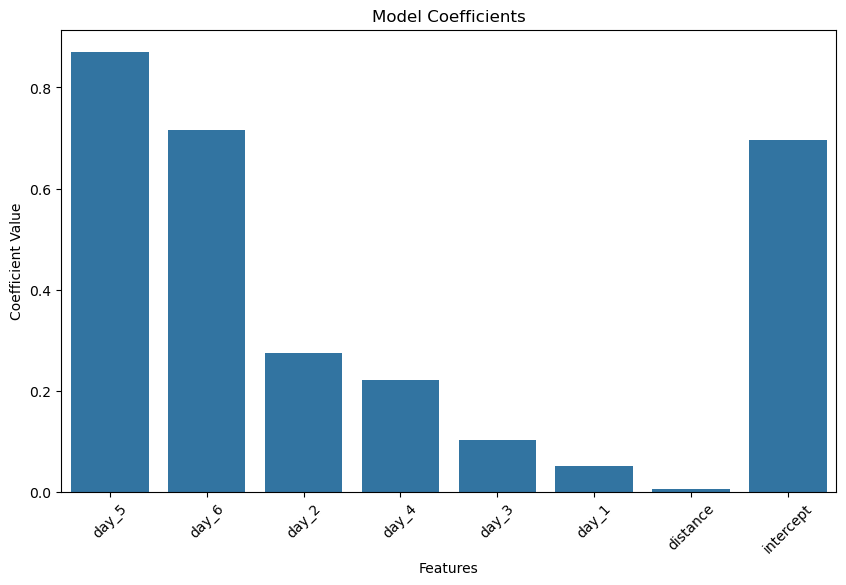

In [74]:
# Creating our multi-linear regression model, predicting the travel time based on the distance and which day of the week it is
## Splitting our data using my_train_test_split function
y = df_model1_dummies_day['travel_time']
X = df_model1_dummies_day.drop(columns=['datetime_1h', 'travel_time'])
X_train, X_test, y_train, y_test = my_train_test_split(X, y)

## Creating our model 1: model1_day
model1_day = LinearRegression()
model1_day.fit(X_train, y_train)

## Retrieval of its coefficient estimates
df_model1_coeffs = build_coeffs_df(model1_day, X)
display(df_model1_coeffs)

## Displaying the model 1's validation serie
y_pred_model1 = model1_day.predict(X_test)
s_model1_validation = build_validation_serie(y_test, y_pred_model1)
display(s_model1_validation)

## Plotting a bar plot of the model's coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x=df_model1_coeffs.index, y='Coefficient', data=df_model1_coeffs.reset_index())
plt.title('Model Coefficients')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=45)
plt.show()


In [75]:
# Adding the dummies column indicating which hour of the day it is
df_model1['hour'] = df_model1['datetime_1h'].dt.hour
df_model1_dummies = pd.get_dummies(df_model1, columns=['day', 'hour'], drop_first=True, dtype="int")
df_model1_dummies.sample(5)

distance  travel_time               datetime_1h  day_1  day_2  \
1621820  1591.668229         10.0 2019-06-05 18:00:00+02:00      0      1   
1465862  1480.578606          6.0 2019-05-30 11:00:00+02:00      0      0   
1300878  2189.344629         11.0 2019-05-24 05:00:00+02:00      0      0   
682022   1488.572339          9.0 2019-04-29 15:00:00+02:00      0      0   
1458034  1403.060302         14.0 2019-05-29 22:00:00+02:00      0      1   

         day_3  day_4  day_5  day_6  hour_1  ...  hour_14  hour_15  hour_16  \
1621820      0      0      0      0       0  ...        0        0        0   
1465862      1      0      0      0       0  ...        0        0        0   
1300878      0      1      0      0       0  ...        0        0        0   
682022       0      0      0      0       0  ...        0        1        0   
1458034      0      0      0      0       0  ...        0        0        0   

         hour_17  hour_18  hour_19  hour_20  hour_21  hour_22  hour_23  
1621820        0        1        0        0        0        0        0  
1465862        0        0        0        0        0        0        0  
1300878        0        0        0        0        0        0        0  
682022         0        0        0        0        0        0        0  
1458034        0        0        0        0        0        1        0  

[5 rows x 32 columns]

Coefficient
day_5         0.743192
day_6         0.567121
hour_15       0.486736
hour_16       0.440375
hour_2        0.324093
hour_1        0.301573
hour_3        0.298755
day_2         0.266025
hour_14       0.261406
hour_17       0.223509
day_4         0.215047
hour_18       0.190113
day_3         0.101188
hour_19       0.082790
day_1         0.064285
distance      0.005722
hour_4       -0.039139
hour_11      -0.057181
hour_20      -0.108295
hour_22      -0.161731
hour_10      -0.199972
hour_12      -0.205553
hour_13      -0.215877
hour_23      -0.218165
hour_21      -0.232617
hour_9       -0.727207
hour_8       -0.782350
hour_5       -1.194533
hour_7       -1.247412
hour_6       -1.629114
intercept     0.846724

R²      0.772160
MSE    10.579705
MAE     2.259664
dtype: float64

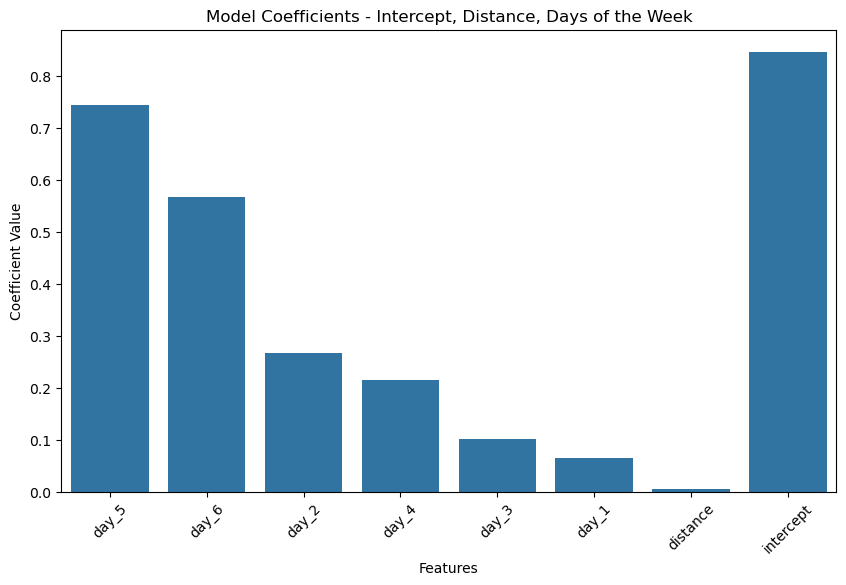

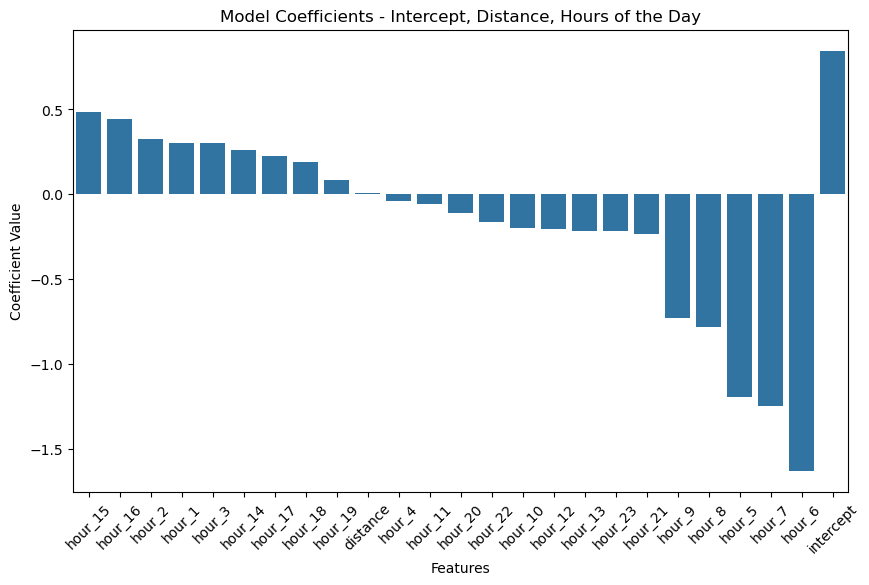

C:\Users\ndamb\AppData\Local\Temp\ipykernel_22820\1607004228.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_model1_coeffs.index, y='Coefficient', data=df_model1_coeffs.reset_index(), palette=colors)


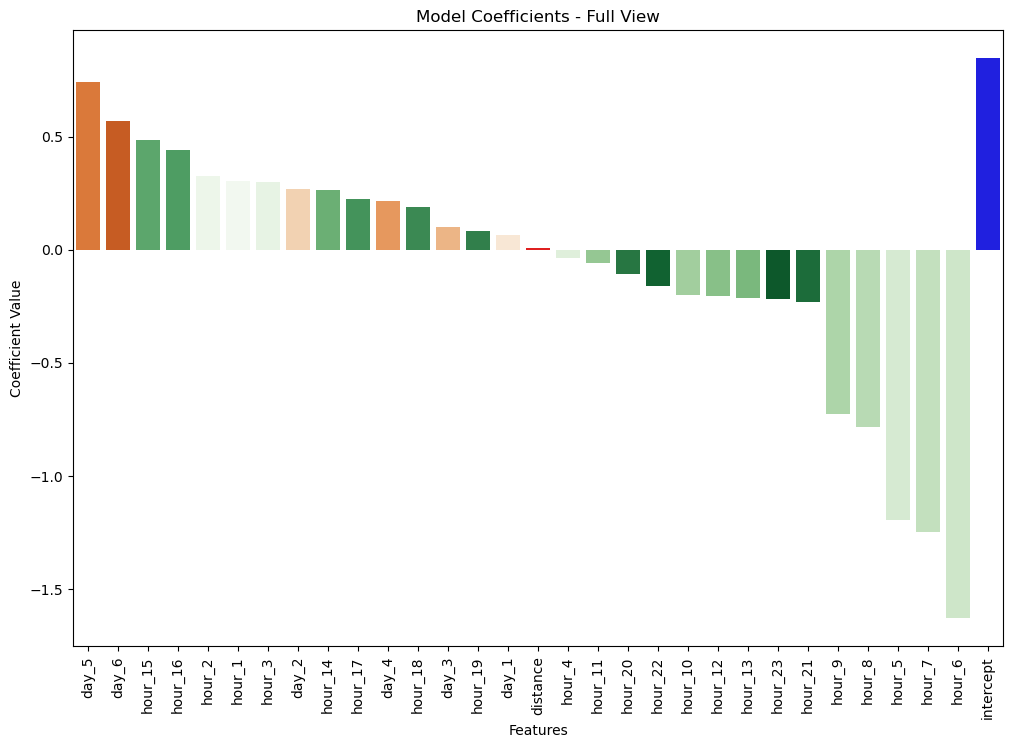

In [76]:
# Creating our multi-linear regression model, predicting the travel time based on the previous parameters and the hour of the day
## Splitting our data using my_train_test_split function
y = df_model1_dummies['travel_time']
X = df_model1_dummies.drop(columns=['datetime_1h', 'travel_time'])
X_train, X_test, y_train, y_test = my_train_test_split(X, y)

## Creating our new model 1: model1_day_hour
model1_day_hour = LinearRegression()
model1_day_hour.fit(X_train, y_train)

## Retrieval of its coefficient estimates
df_model1_coeffs = build_coeffs_df(model1_day_hour, X)
display(df_model1_coeffs)

## Displaying the model 1's validation serie
y_pred_model1_day_hour = model1_day_hour.predict(X_test)
s_model1_day_hour_validation = build_validation_serie(y_test, y_pred_model1_day_hour)
display(s_model1_day_hour_validation)

## Plotting 3 bar plots of the model's coefficients
### Plotting the first bar plot with the intercept, the distance and the days of the week
df_days = df_model1_coeffs[df_model1_coeffs.index.isin(['intercept', 'distance']) | df_model1_coeffs.index.str.startswith('day_')]
plt.figure(figsize=(10, 6))
sns.barplot(x=df_days.index, y='Coefficient', data=df_days.reset_index())
plt.title('Model Coefficients - Intercept, Distance, Days of the Week')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=45)
plt.show()

### Plotting the second bar plot with the intercept, the distance and the hours of the day
df_hours = df_model1_coeffs[df_model1_coeffs.index.isin(['intercept', 'distance']) | df_model1_coeffs.index.str.startswith('hour_')]
plt.figure(figsize=(10, 6))
sns.barplot(x=df_hours.index, y='Coefficient', data=df_hours.reset_index())
plt.title('Model Coefficients - Intercept, Distance, Hours of the Day')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=45)
plt.show()

### Plotting the last bar plot with all the coefficients and setting 2 different colors
### for the intercept and the distance, and setting 2 different gradient for the hours of the day
### and the days of the week
plt.figure(figsize=(12, 8))
colors = []
for idx in df_model1_coeffs.index:
    if idx == 'intercept':
        colors.append('blue')
    elif idx == 'distance':
        colors.append('red')
    elif idx.startswith('day_'):
        colors.append(plt.cm.Oranges(int(idx.split('_')[1]) * 30))
    elif idx.startswith('hour_'):
        colors.append(plt.cm.Greens(int(idx.split('_')[1]) * 10))
    else:
        colors.append('gray')
sns.barplot(x=df_model1_coeffs.index, y='Coefficient', data=df_model1_coeffs.reset_index(), palette=colors)
plt.title('Model Coefficients - Full View')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=90)
plt.show()

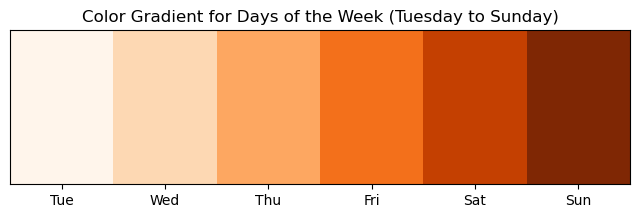

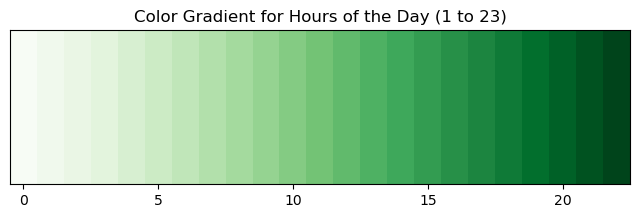

In [77]:
# Plotting a legend for the previous code that plotted the complete bar graph
## Plotting a gradient to show the colors grading from Tuesday to Sunday (1 to 6)
plt.figure(figsize=(8, 2))
gradient_days = np.linspace(0, 1, 6).reshape(1, -1)
plt.imshow(gradient_days, aspect='auto', cmap='Oranges')
plt.title('Color Gradient for Days of the Week (Tuesday to Sunday)')
# Changing the legend to show the days of the week
plt.xticks(ticks=np.arange(6), labels=['Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.yticks([])
plt.show()

## Plotting a gradient to show the colors grading from Hour 1 to Hour 23
plt.figure(figsize=(8, 2))
gradient_hours = np.linspace(0, 1, 23).reshape(1, -1)
plt.imshow(gradient_hours, aspect='auto', cmap='Greens')
plt.title('Color Gradient for Hours of the Day (1 to 23)')
plt.yticks([])
plt.show()

In [78]:
# Estimating 15km travel times with different hours of the day and days of the week with model1_day_hour
TT_5km_model1_day_hour = {}
for day in range(7):
    for hour in range(24):
        # Creating a dataframe with the distance, day and hour
        data = {'distance': [5000]}
        for d in range(1, 7):
            data[f'day_{d}'] = [1 if d == day else 0]
        for h in range(1, 24):
            data[f'hour_{h}'] = [1 if h == hour else 0]
        X_temp = pd.DataFrame(data)
        # Predicting the travel time
        TT_5km_model1_day_hour[(day, hour)] = model1_day_hour.predict(X_temp)[0]

# Displaying the estimated travel times for a 15km trip in a dataframe
print("Estimated travel times for a 5km trip (in minutes) depending on the day of the week and the hour of the day:")
df_TT_5km_model1_day_hour = pd.DataFrame.from_dict(TT_5km_model1_day_hour, orient='index', columns=['Estimated Travel Time (minutes)'])
df_TT_5km_model1_day_hour.index = pd.MultiIndex.from_tuples(df_TT_5km_model1_day_hour.index, names=['Day of the Week', 'Hour of the Day'])
df_TT_5km_model1_day_hour = df_TT_5km_model1_day_hour.sort_index()
df_TT_5km_model1_day_hour.sample(10)

Estimated travel times for a 5km trip (in minutes) depending on the day of the week and the hour of the day:


Estimated Travel Time (minutes)
Day of the Week Hour of the Day                                 
2               22                                     29.562716
4               2                                      29.997563
6               5                                      28.831011
3               0                                      29.559610
0               5                                      28.263890
1               19                                     29.605497
6               6                                      28.396429
3               8                                      28.777260
                1                                      29.861183
                10                                     29.359638

In [79]:
from functions.estimator import MLR_model_estimator

# Example
test_distance = 15000  # in meters
test_travel_time = None  # unknown, to be predicted
test_datetime_1h = '2020-01-07 08:15:00'  # example datetime
test_day = 1  # Tuesday
test_month = 1  # January

sample_list = [test_distance, test_travel_time, test_datetime_1h, test_day, test_month]
pred = MLR_model_estimator(
    model=model1_day_hour,
    features=sample_list,
    feature_names=['distance','travel_time','datetime_1h','day','month'],
    model_feature_names=X.columns,   # X is the training DataFrame's columns used to fit the model
    show_steps=True
)
print(f"The predicted travel time for a {test_distance/1000} km trip is: {round(pred)} minutes")

[STEP] Starting estimation
[STEP] Extracted base features: {'distance': 15000, 'day': 1, 'datetime_1h': '2020-01-07 08:15:00', 'month': 1}
[STEP] distance = 15000.0
[STEP] Using provided day = 1
[STEP] Derived hour from datetime_1h = 8
[STEP] Using provided month = 1
[STEP] Using provided model_feature_names
[INFO] model will expect 30 features: ['distance', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23']
[STEP] Built input vector (first 10 values shown): [1.5e+04 1.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00
 0.0e+00]
[STEP] Model intercept = 0.8467243488019722
[STEP] Model has 30 coefficients; input vector length = 30
[RESULT] Predicted travel time = 85.96375305430517
The predicted travel time for a 15.0 km trip is: 86 m

#### b/ Model 2 - Adding the temperature, the rain, and the wind

In [80]:
# Extracting a subset of our original dataframe with only the columns at use
df_model2 = df_meteo[['distance', 'travel_time', 'datetime_1h', 'day', 'temp_category', 'rain_category', 'wind_category']].copy()
df_model2['hour'] = df_model2['datetime_1h'].dt.hour
# Filtering out the rows with 'unknown' categories
df_model2 = df_model2[
    (df_model2['temp_category'] != 'unknown') &
    (df_model2['wind_category'] != 'unknown')
].copy()
# Converting day and hour to integer type
df_model2['day'] = df_model2['day'].astype(int)
df_model2['hour'] = df_model2['hour'].astype(int)
df_model2.sample(5)

distance  travel_time               datetime_1h  day  \
1533817  1836.171378         21.0 2019-06-13 20:00:00+02:00    3   
238212   3506.475075         20.0 2019-04-11 03:00:00+02:00    3   
1331332  2178.839017         14.0 2019-06-02 21:00:00+02:00    6   
1515570  2291.561914         15.0 2019-06-13 07:00:00+02:00    3   
1194179  1957.834097         10.0 2019-05-27 07:00:00+02:00    0   

        temp_category rain_category wind_category  hour  
1533817          warm          none         light    20  
238212           warm          none         windy     3  
1331332     very_warm          none         light    21  
1515570          warm          none         light     7  
1194179          warm      moderate         light     7

In [81]:
df_model2_dummies_hours_days = pd.get_dummies(df_model2, columns=['day', 'hour'], drop_first=True, dtype="int")
df_model2_dummies = pd.get_dummies(df_model2_dummies_hours_days, columns=['temp_category', 'rain_category', 'wind_category'], drop_first=True, dtype="int")
df_model2_dummies.sample(5)

distance  travel_time               datetime_1h  day_1  day_2  \
1116277  2189.228451         21.0 2019-05-23 17:00:00+02:00      0      0   
213104   1232.928919          9.0 2019-04-10 08:00:00+02:00      0      1   
1298616  1042.449418          8.0 2019-05-31 19:00:00+02:00      0      0   
1291106  1756.071274          7.0 2019-05-31 13:00:00+02:00      0      0   
1091369  1511.650981         12.0 2019-05-22 18:00:00+02:00      0      1   

         day_3  day_4  day_5  day_6  hour_1  ...  hour_21  hour_22  hour_23  \
1116277      1      0      0      0       0  ...        0        0        0   
213104       0      0      0      0       0  ...        0        0        0   
1298616      0      1      0      0       0  ...        0        0        0   
1291106      0      1      0      0       0  ...        0        0        0   
1091369      0      0      0      0       0  ...        0        0        0   

         temp_category_very_warm  temp_category_warm  rain_category_light  \
1116277                        0                   1                    0   
213104                         0                   1                    0   
1298616                        0                   1                    0   
1291106                        0                   1                    0   
1091369                        0                   1                    0   

         rain_category_moderate  rain_category_none  wind_category_light  \
1116277                       0                   1                    0   
213104                        0                   1                    1   
1298616                       0                   1                    0   
1291106                       0                   1                    0   
1091369                       0                   1                    1   

         wind_category_windy  
1116277                    0  
213104                     0  
1298616                    0  
1291106                    0  
1091369                    0  

[5 rows x 39 columns]

In [82]:
df_model2_dummies.columns

Index(['distance', 'travel_time', 'datetime_1h', 'day_1', 'day_2', 'day_3',
       'day_4', 'day_5', 'day_6', 'hour_1', 'hour_2', 'hour_3', 'hour_4',
       'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11',
       'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17',
       'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23',
       'temp_category_very_warm', 'temp_category_warm', 'rain_category_light',
       'rain_category_moderate', 'rain_category_none', 'wind_category_light',
       'wind_category_windy'],
      dtype='object')

Coefficient
day_5                       0.754831
day_6                       0.643499
hour_15                     0.475817
rain_category_none          0.451164
hour_16                     0.426971
day_2                       0.342639
temp_category_very_warm     0.341119
hour_2                      0.326249
hour_3                      0.312339
hour_1                      0.301452
hour_14                     0.248702
rain_category_light         0.229615
hour_17                     0.216508
day_4                       0.201198
hour_18                     0.180822
day_3                       0.139432
temp_category_warm          0.125751
day_1                       0.120177
rain_category_moderate      0.093614
hour_19                     0.065531
distance                    0.005714
hour_4                     -0.040414
hour_11                    -0.064838
hour_20                    -0.130185
wind_category_light        -0.160166
hour_22                    -0.185637
hour_10                    -0.210553
hour_12                    -0.216653
hour_13                    -0.227357
hour_23                    -0.242026
hour_21                    -0.256455
wind_category_windy        -0.265127
hour_9                     -0.732150
hour_8                     -0.777497
hour_5                     -1.199282
hour_7                     -1.241208
hour_6                     -1.626783
intercept                   0.485209

R²      0.772708
MSE    10.554260
MAE     2.283215
dtype: float64

C:\Users\ndamb\AppData\Local\Temp\ipykernel_22820\1284437890.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_model2_coeffs.index, y='Coefficient', data=df_model2_coeffs.reset_index(), palette=colors)


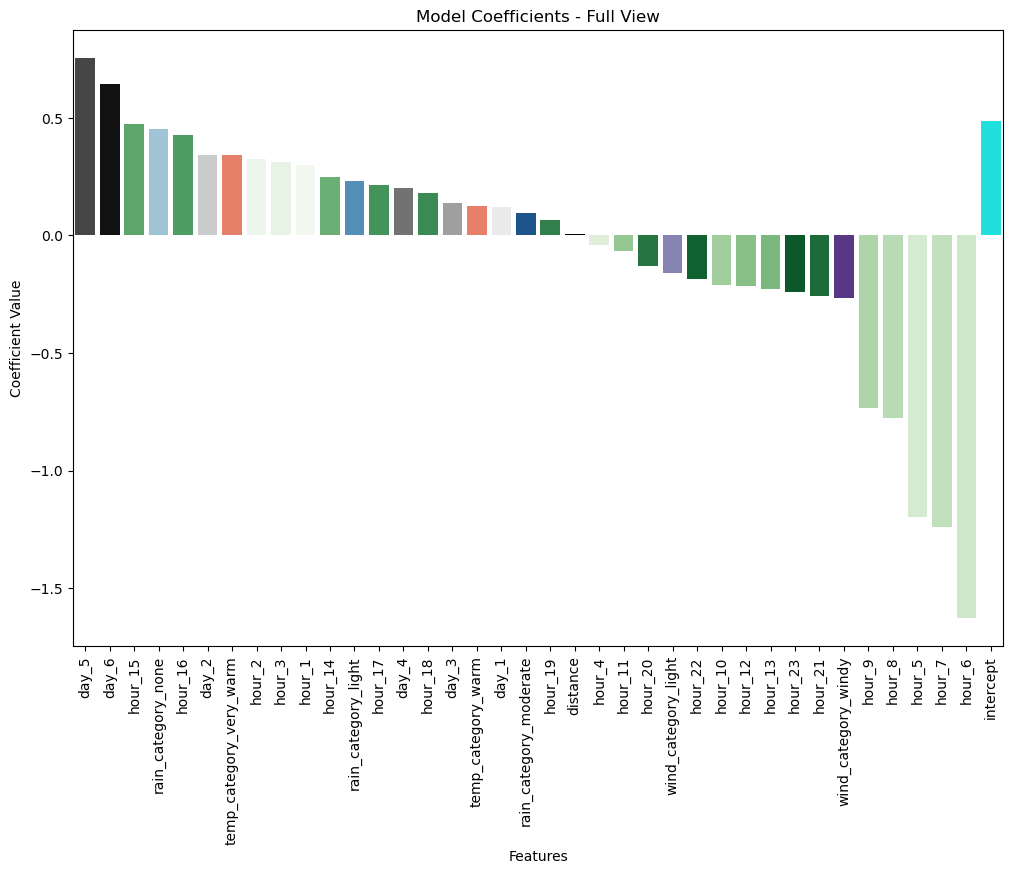

In [83]:
# Creating our multi-linear regression model, predicting the travel time based on the distance and which day of the week it is
## Splitting our data using my_train_test_split function
y = df_model2_dummies['travel_time']
X = df_model2_dummies.drop(columns=['datetime_1h', 'travel_time'])
X_train, X_test, y_train, y_test = my_train_test_split(X, y)

## Creating our model 2
model2 = LinearRegression()
model2.fit(X_train, y_train)

## Retrieval of its coefficient estimates
df_model2_coeffs = build_coeffs_df(model2, X)
display(df_model2_coeffs)

## Displaying the model 1's validation serie
y_pred_model2 = model2.predict(X_test)
s_model2_validation = build_validation_serie(y_test, y_pred_model2)
display(s_model2_validation)

## Plotting a bar plot of the model's coefficients with separate colors for the different types of features
plt.figure(figsize=(12, 8))
colors = []
for idx in df_model2_coeffs.index:
    # Intercept is in cyan and is an interger (in minutes)
    if idx == 'intercept':
        colors.append('cyan')
    # Distance is in black and is an integer (in min/m)
    elif idx == 'distance':
        colors.append('black')
    # The days are a gradient from grey to black and are to be converted in integers based on the last digit
    elif idx.startswith('day_'):
        colors.append(plt.cm.Greys(int(idx.split('_')[1]) * 40))
    # The hours are a gradient of green and are to be converted in integers based on the last digit
    elif idx.startswith('hour_'):
        colors.append(plt.cm.Greens(int(idx.split('_')[1]) * 10))
    # The temperature is a gradient of red and is composed of categories (strings) 
    elif idx.startswith('temp_category_'):
        colors.append(plt.cm.Reds((['cold', 'cool', 'warm', 'very_warm'].index(idx.split('_')[-1])) * 60))
    # The rain is a gradient of deep blue and is composed of categories (strings)
    elif idx.startswith('rain_category_'):
        colors.append(plt.cm.Blues((['none', 'light', 'moderate', 'heavy'].index(idx.split('_')[-1])) * 60 + 100))
    # The wind is in purple and is composed of categories (strings)
    elif idx.startswith('wind_category_'):
        colors.append(plt.cm.Purples((['calm', 'light', 'windy', 'stormy'].index(idx.split('_')[-1])) * 60 + 100))
    else:
        colors.append('gray')
sns.barplot(x=df_model2_coeffs.index, y='Coefficient', data=df_model2_coeffs.reset_index(), palette=colors)
plt.title('Model Coefficients - Full View')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=90)
plt.show()

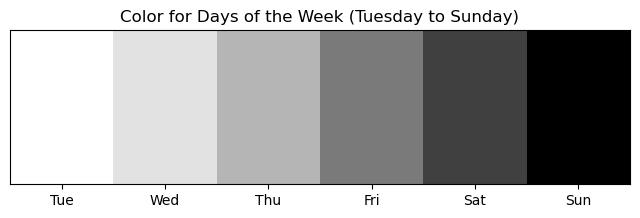

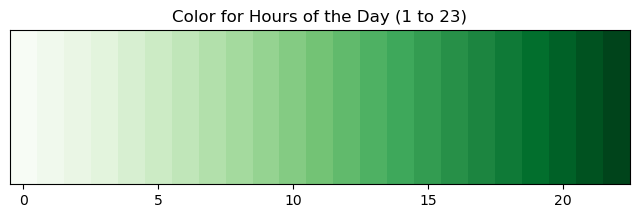

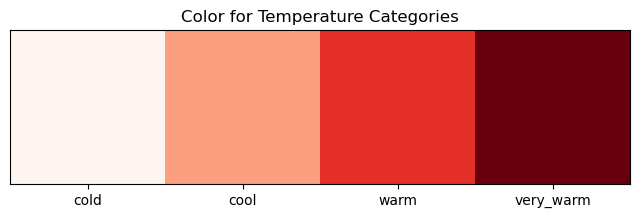

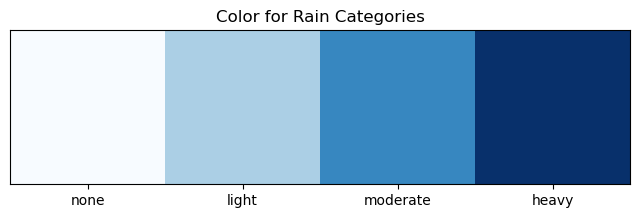

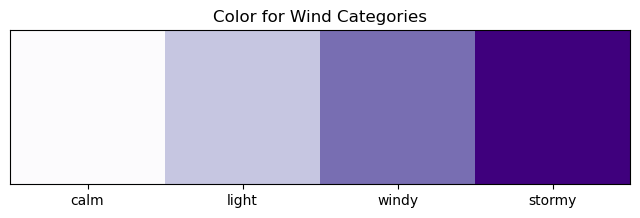

In [84]:
# Plotting the color legends for the previous code that plotted the complete bar graph
## Gradient of Grey colors for Days of the Week (Tuesday to Sunday)
plt.figure(figsize=(8, 2))
gradient_days = np.linspace(0, 1, 6).reshape(1, -1)
plt.imshow(gradient_days, aspect='auto', cmap='Greys')
plt.title('Color for Days of the Week (Tuesday to Sunday)')
# Changing the legend to show the days of the week
plt.xticks(ticks=np.arange(6), labels=['Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.yticks([])
plt.show()
## Gradient of green colors for Hours of the Day (1 to 23)
plt.figure(figsize=(8, 2))
gradient_hours = np.linspace(0, 1, 23).reshape(1, -1)
plt.imshow(gradient_hours, aspect='auto', cmap='Greens')
plt.title('Color for Hours of the Day (1 to 23)')
plt.yticks([])
plt.show()
## Gradient of red colors for temperature categories
plt.figure(figsize=(8, 2))
categories_temp = ["cold", "cool", "warm", "very_warm"]
gradient_temp = np.linspace(0, 1, 4).reshape(1, -1)
plt.imshow(gradient_temp, aspect='auto', cmap='Reds', vmin=0, vmax=1)
plt.title('Color for Temperature Categories')
# Changing the legend to show the temperature categories
plt.xticks(ticks=np.arange(len(categories_temp)), labels=categories_temp)
plt.yticks([])
plt.show()
## Gradient of blue colors for rain categories
plt.figure(figsize=(8, 2))
categories_RR = ["none", "light", "moderate", "heavy"]
gradient_RR = np.linspace(0, 1, 4).reshape(1, -1)
plt.imshow(gradient_RR, aspect='auto', cmap='Blues', vmin=0, vmax=1)
plt.title('Color for Rain Categories')
# Changing the legend to show the rain categories
plt.xticks(ticks=np.arange(len(categories_RR)), labels=categories_RR)
plt.yticks([])
plt.show()
## Gradient of purple colors for wind categories
plt.figure(figsize=(8, 2))
categories_wind = ["calm", "light", "windy", "stormy"]
gradient_wind = np.linspace(0, 1, 4).reshape(1, -1)
plt.imshow(gradient_wind, aspect='auto', cmap='Purples', vmin=0, vmax=1)
plt.title('Color for Wind Categories')
# Changing the legend to show the wind categories
plt.xticks(ticks=np.arange(len(categories_wind)), labels=categories_wind)
plt.yticks([])
plt.show()

#### c/ Model 3 - Clusters

##### i. Clusters creation

In [85]:
gdf_stations.to_crs(epsg=4326, inplace=True)
# Extracting the longitude & latitude of stations
gdf_stations['longitude'] = gdf_stations.geometry.centroid.x
gdf_stations['latitude'] = gdf_stations.geometry.centroid.y

gdf_useful = gdf_stations[['idstation', 'longitude', 'latitude']]

print(gdf_useful.head())

   idstation  longitude   latitude
0       7024   4.840525  45.748520
1      10063   4.885609  45.758392
2      10021   4.889947  45.759718
3       8038   4.867429  45.746716
4       7045   4.824488  45.737741


C:\Users\ndamb\AppData\Local\Temp\ipykernel_22820\4066190429.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_stations['longitude'] = gdf_stations.geometry.centroid.x
C:\Users\ndamb\AppData\Local\Temp\ipykernel_22820\4066190429.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_stations['latitude'] = gdf_stations.geometry.centroid.y


In [86]:
# Define the coordinates of each cluster center
clusters_centers = {
    'LA_DOUA': (45.783479, 4.875842),
    'TETE_D_OR': (45.778341, 4.853017),
    'LA_PART_DIEU': (45.761882, 4.855204),
    'OLD_TOWN': (45.764043, 4.835659),
    'CONFLUENCE': (45.732634, 4.819839),
    'FOURVIERE': (45.762455, 4.821639),
    'CROIX_ROUSSE': (45.775873,4.830042 )
}

# Define the radius of influence for each cluster in METERS
clusters_radius = {
    'LA_DOUA': 1000,
    'TETE_D_OR': 900,
    'LA_PART_DIEU': 500,
    'OLD_TOWN': 500,
    'CONFLUENCE': 1000,
    'FOURVIERE': 700,
    'CROIX_ROUSSE': 500
}

# Define the color in which the cluster shall appear on the map
color_map = {
    'LA_DOUA': 'red',
    "TETE_D_OR": 'green',
    'LA_PART_DIEU': 'orange',
    'OLD_TOWN': 'purple',
    'CONFLUENCE': 'cyan',
    'FOURVIERE': 'magenta',
    'CROIX_ROUSSE': 'brown',
    'NO_CLUSTER': 'gray'
}

for name, (lat_c, lon_c) in clusters_centers.items():
    distances = haversine(
        gdf_useful['longitude'], gdf_useful['latitude'],
        lon_c, lat_c
    )
    gdf_useful[name] = (distances*1000 < clusters_radius[name]).astype(int)

# Creating a column indicating if a station does not belong to any cluster
gdf_useful['NO_CLUSTER'] = (gdf_useful[list(clusters_centers.keys())].sum(axis=1) == 0).astype(int)

gdf_useful.head(10)

C:\Users\ndamb\AppData\Local\Temp\ipykernel_22820\2591392750.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf_useful[name] = (distances*1000 < clusters_radius[name]).astype(int)
C:\Users\ndamb\AppData\Local\Temp\ipykernel_22820\2591392750.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf_useful[name] = (distances*1000 < clusters_radius[name]).astype(int)
C:\Users\ndamb\AppData\Local\Temp\ipykernel_22820\2591392750.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

idstation  longitude   latitude  LA_DOUA  TETE_D_OR  LA_PART_DIEU  \
0       7024   4.840525  45.748520        0          0             0   
1      10063   4.885609  45.758392        0          0             0   
2      10021   4.889947  45.759718        0          0             0   
3       8038   4.867429  45.746716        0          0             0   
4       7045   4.824488  45.737741        0          0             0   
5       6045   4.857002  45.766367        0          0             0   
6       8056   4.856813  45.735795        0          0             0   
7       8015   4.874194  45.740326        0          0             0   
8       7057   4.835497  45.734725        0          0             0   
9       7007   4.827719  45.735674        0          0             0   

   OLD_TOWN  CONFLUENCE  FOURVIERE  CROIX_ROUSSE  NO_CLUSTER  
0         0           0          0             0           1  
1         0           0          0             0           1  
2         0           0          0             0           1  
3         0           0          0             0           1  
4         0           1          0             0           0  
5         0           0          0             0           1  
6         0           0          0             0           1  
7         0           0          0             0           1  
8         0           0          0             0           1  
9         0           1          0             0           0

##### ii. Testing the realism of the restriction

In [87]:
print("Number of stations in")
for cluster in clusters_centers.keys():
    print(f"{cluster} :", gdf_useful[cluster].sum(), ", soit ", round(gdf_useful[cluster].sum() / gdf_useful.shape[0] * 100, ndigits=2), "%")

# Nombre de stations non assignées à un cluster
print("NO_CLUSTER :", gdf_useful['NO_CLUSTER'].sum(), ", soit ", round(gdf_useful['NO_CLUSTER'].sum() / gdf_useful.shape[0] * 100, ndigits=2), "%")

Number of stations in
LA_DOUA : 11 , soit  2.55 %
TETE_D_OR : 11 , soit  2.55 %
LA_PART_DIEU : 8 , soit  1.86 %
OLD_TOWN : 14 , soit  3.25 %
CONFLUENCE : 10 , soit  2.32 %
FOURVIERE : 4 , soit  0.93 %
CROIX_ROUSSE : 4 , soit  0.93 %
NO_CLUSTER : 369 , soit  85.61 %


In [88]:
clusters_centroids = {}

# Number of significant digits for centroid coordinate calculations
n_ = 5 # +1 !

for cluster in clusters_centers.keys():
    # Filter stations close to the location (value = 1)
    subset = gdf_useful[gdf_useful[cluster] == 1]

    # Calculate the mean coordinates
    mean_lat = subset['latitude'].mean()
    mean_lon = subset['longitude'].mean()

    # Store the rounded centroid in the dictionary
    clusters_centroids[cluster] = (round(mean_lat, ndigits=n_), round(mean_lon, ndigits=n_))

# Cleanup
del mean_lat, mean_lon, subset, n_

clusters_centroids


{'LA_DOUA': (np.float64(45.78069), np.float64(4.87601)),
 'TETE_D_OR': (np.float64(45.77933), np.float64(4.8545)),
 'LA_PART_DIEU': (np.float64(45.76148), np.float64(4.85481)),
 'OLD_TOWN': (np.float64(45.76404), np.float64(4.83482)),
 'CONFLUENCE': (np.float64(45.73393), np.float64(4.82105)),
 'FOURVIERE': (np.float64(45.76333), np.float64(4.82192)),
 'CROIX_ROUSSE': (np.float64(45.77517), np.float64(4.83069))}

C:\Users\ndamb\AppData\Local\Temp\ipykernel_22820\3690563415.py:72: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle(
C:\Users\ndamb\AppData\Local\Temp\ipykernel_22820\3690563415.py:72: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle(
C:\Users\ndamb\AppData\Local\Temp\ipykernel_22820\3690563415.py:72: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle(
C:\Users\ndamb\AppData\Local\Temp\ipykernel_22820\3690563415.py:72: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle(
C:\Users\ndamb\AppData\Local\Temp\ipykernel_22820\3690563415.py:72: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle(
C:\Users\ndamb\AppData\Local\Temp\ipykernel_22820\3690563415.py:72: Us

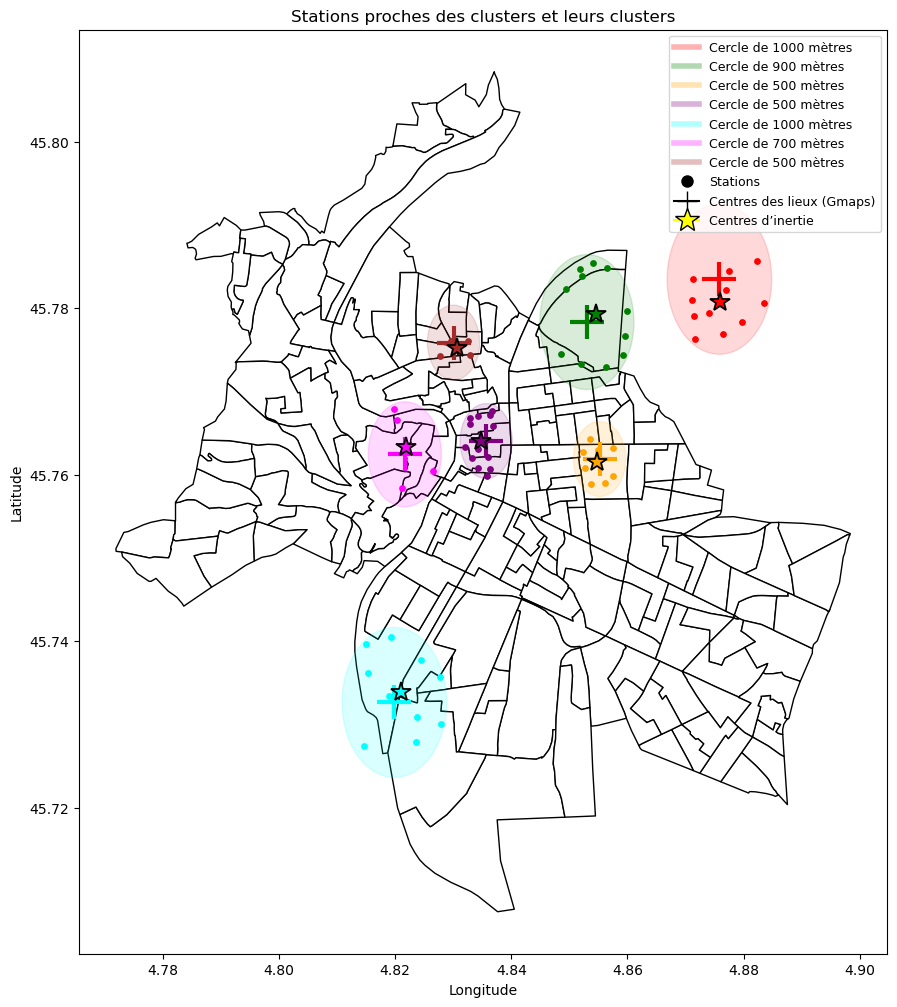

✅ Map with points, centroids, and centers successfully plotted.


In [89]:
##### Modifiable parameters for the visualization of þe clusters ####
#####################################################################

all_stations = False
# Size of the points representing þe clustered stations 
size1 = 15

# Size of þe stations outside of clusters
size0 = 10

# Loading þe shapefile
gdf = gpd.read_file(LYON_IRIS)
gdf.to_crs(epsg=4326, inplace=True)

# Converting gdf_useful in GeoDataFrame of points
gdf_points = gpd.GeoDataFrame(
    gdf_useful,
    geometry=gpd.points_from_xy(gdf_useful.longitude, gdf_useful.latitude),
    crs="EPSG:4326"  # car mes coordonnées sont en lat/lon
)

fig, ax = plt.subplots(figsize=(12, 12))

# Map background
gdf.plot(ax=ax, facecolor="white", edgecolor="black")

legend_handles = []  # to create a proper legend

for place, (lat_c, lon_c) in clusters_centers.items():

    tol    = clusters_radius[place]  # Tolérance en mètres
    color0 = color_map[place]

    # -----------------------------
    # 1/6 Stations proches (points)
    # -----------------------------
    pts = gdf_points[gdf_points[place] == 1].plot(
        ax         = ax,
        color      = color0,
        markersize = size1
    )
    
    # -----------------------------
    # 2/6 Centre exact du lieu (+)
    # -----------------------------
    ax.plot(
        lon_c, lat_c,
        marker     = "+",
        markersize = 25,
        color      = color0,
        mew        = 3
    )

    # -----------------------------
    # 3/6 Centre d’inertie (étoile)
    # -----------------------------
    lat_mean, lon_mean = clusters_centroids[place]
    ax.plot(
        lon_mean, lat_mean,
        marker     = "*",
        markersize = 15,
        color      = color0,
        markeredgecolor = "black",
        markeredgewidth=1.3
    )

    # -----------------------------
    # 4/6 Cercle (buffer de 1 km)
    # -----------------------------
    # Conversion approx. km → degrés (1° lat ≈ 111 km)
    km_to_deg = tol / (111 * 1000)
    circle = plt.Circle(
        (lon_c, lat_c),
        km_to_deg,
        color=color0,
        alpha=0.15,
        edgecolor=color0
    )
    ax.add_patch(circle)

    legend_handles.append(
        plt.Line2D([0], [0], color=color0, lw=4, alpha=0.3,
                    label=f"Cercle de {tol} mètres")
    )


# -----------------------------
# 5/6 Stations en dehors des clusters (points)
# -----------------------------
if all_stations:
    color0 = color_map['NO_CLUSTER']
    pts = gdf_points[gdf_points['NO_CLUSTER'] == 1].plot(
    ax         = ax,
    color      = color0,
    markersize = size0
    )

# -----------------------------
# 6/6 Éléments pour la légende
# -----------------------------
legend_handles.append(
    plt.Line2D([0], [0], marker='o', color='white', markerfacecolor='black',
                label=f"Stations", markersize=10)
)
legend_handles.append(
    plt.Line2D([0], [0], marker='+', color='black', markersize=15,
                label=f"Centres des lieux (Gmaps)")
)
legend_handles.append(
    plt.Line2D([0], [0], marker='*', color='yellow', markeredgecolor='black',
                markersize=18, label=f"Centres d’inertie")
)
    
# --- Mise en forme finale ---
plt.title(f"Stations proches des clusters et leurs clusters")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(handles=legend_handles, loc='upper right', fontsize=9)
plt.grid(False)

plt.show()
print("✅ Map with points, centroids, and centers successfully plotted.")

##### iii. Adding the `cluster_exit` and `cluster_return` columns

In [ ]:
# This part doesn't work (ran for 45 minutes until 109%...)
# 
# # Creating df_model3_dummies following the same steps than 
## df_model2_dummies but with the columns "id_exit_station"
## and "id_return_station" in addition
## With print statements to observe each step
#
### Restarting from df_meteo (copy) and including the 2 columns
#df_model3 = df_meteo[['distance', 'travel_time', 'datetime_1h', 'day', 'temp_category', 'rain_category', 'wind_category', 'id_exit_station', 'id_return_station']].copy()
#df_model3['hour'] = df_model3['datetime_1h'].dt.hour
#print("Step 1: Created df_model3 with relevant columns.")
#
### Creating a function "get_cluster_name" that returns the name
### of the cluster based on the column where there's a 1
#N_stations_assigned = 0
#def get_cluster_name(row, exit_or_return):
#    '''
#    Arguments:
#        row: a row of df_model3
#        exit_or_return: (str) indicates whether to change the id_exit_station or the id_return_station
#    '''
#    # Counting the number of travels assigned to a cluster
#    global N_stations_assigned
#    N_stations_assigned += 1
#    progress = N_stations_assigned / df_model3.shape[0] * 100
#    print(round(progress, 1), "%' of travels assigned to a cluster.", end='\r')
#    # Extracting the station id
#    station_id = row[f'id_{exit_or_return}_station']
#    # Extracting the 0s and the 1 from the clusters columns as tuple (name, 0 or 1)
#    station_clusters = []
#    for cluster_name in clusters_centers.keys():
#        station_clusters.append((
#            cluster_name,
#            gdf_useful.loc[
#                gdf_useful['idstation'] == station_id,
#                cluster_name
#            ].values[0]))
#    # Testing if there is a one
#    for (cluster_name, is_in_cluster) in station_clusters:
#        # Extracting the name of the cluster with a one
#        if is_in_cluster == 1:
#            return cluster_name
#    return 'NO_CLUSTER'
#
### Using "get_cluster_name" to turn the columns "id_exit_station"
### and "id_return_station" into "exit_cluster" and "return_cluster"
#df_model3['exit_cluster'] = df_model3.apply(lambda row: get_cluster_name(row, 'exit'), axis=1)
#df_model3['return_cluster'] = df_model3.apply(lambda row: get_cluster_name(row, 'return'), axis=1)
#print("Step 2: Mapped station IDs to cluster names.")
#
## Filtering out the rows with 'unknown' categories
#df_model3 = df_model3[
#    (df_model3['temp_category'] != 'unknown') &
#    (df_model3['wind_category'] != 'unknown')
#].copy()
#
## Converting day and hour to integer type
#df_model3['day'] = df_model3['day'].astype(int)
#df_model3['hour'] = df_model3['hour'].astype(int)
#
#df_model3_dummies_hours_days = pd.get_dummies(df_model3, columns=['day', 'hour'], drop_first=True, dtype="int")
#df_model3_dummies = pd.get_dummies(df_model3_dummies_hours_days, columns=['temp_category'], drop_first=True, dtype="int")
#df_model3_dummies = pd.get_dummies(df_model3_dummies, columns=['rain_category'], drop_first=True, dtype="int")
#df_model3_dummies = pd.get_dummies(df_model3_dummies, columns=['wind_category'], drop_first=True, dtype="int")
#df_model3_dummies = pd.get_dummies(df_model3_dummies, columns=['exit_cluster', 'return_cluster'], drop_first=True, dtype="int")
#print("Step 3: Created dummies for categorical variables.")
#
#df_model3_dummies.sample(5)

#### d/ Model 4 - Elevation

Goal: Evaluate the impact of elevation and precise travel metrics on OD travel time.

Process:

1. Filter out travels where start or end stations are not assigned to a cluster.
2. Define a reference matrix (Manual Data from Google Maps).
3. Merge this reference data into the main dataframe.

In [ ]:
print("Starting Elevation and Google Maps Data Integration")

# 1a. Ensure df_model3 has exit_cluster / return_cluster (map station id -> cluster)

# The notebook dataset uses station ids (id_exit_station / id_return_station).
# We build a mapping from gdf_points (which contains cluster indicator columns)
# and map it to df_model3. If mapping is missing we default to 'NO_CLUSTER'.

cluster_cols = [
    "LA_DOUA", "TETE_D_OR", "LA_PART_DIEU", "OLD_TOWN",
    "CONFLUENCE", "FOURVIERE", "CROIX_ROUSSE"
]

# Build mapping from station id to cluster name using gdf_points if available
mapping = {}
if 'gdf_points' in globals() and 'idstation' in gdf_points.columns:
    # iterate rows of gdf_points and detect the cluster column set to 1
    for _, prow in gdf_points.iterrows():
        sid = prow['idstation']
        found = None
        for c in cluster_cols:
            if c in gdf_points.columns and prow.get(c, 0) == 1:
                found = c
                break
        mapping[sid] = found if found is not None else 'NO_CLUSTER'
    # add float keys too so mapping works when id columns are float
    mapping.update({float(k): v for k, v in list(mapping.items())})
else:
    # if gdf_points is not available, we won't be able to map -> mark as NO_CLUSTER
    mapping = {}

# Map to df_model3. safe mapping with fillna('NO_CLUSTER')
df_model3['exit_cluster'] = df_model3['id_exit_station'].map(mapping).fillna('NO_CLUSTER')
# id_return_station may be float / NaN; mapping dict has float keys already
df_model3['return_cluster'] = df_model3['id_return_station'].map(mapping).fillna('NO_CLUSTER')

# 1b. Eliminate exit and return stations outside of clusters

# We filter out rows where the cluster mapping returned 'NO_CLUSTER' (from previous step)
# or if there are any NaN values in these columns.

initial_shape = df_model3.shape
df_model3 = df_model3[
    (df_model3['exit_cluster'] != 'NO_CLUSTER') & 
    (df_model3['return_cluster'] != 'NO_CLUSTER') &
    (df_model3['exit_cluster'].notna()) & 
    (df_model3['return_cluster'].notna())
].copy()

rows_removed = initial_shape[0] - df_model3.shape[0]
print(f"Step 4.1: Filtered out {rows_removed} travels with unclustered stations.")
print(f"Remaining travels: {df_model3.shape[0]}")

In [ ]:
# 2. Define the Reference Data (Google Maps Source)

# Manual entry of Distance, Time, Elevation Gain (D+), Elevation Loss (D-)
# between the centroids of the identified clusters.

raw_google_data = [
    # --- START : La Doua ---
    {"start": "La Doua", "end": "La Doua",    "dist": 0,    "time": 0,  "d+": 0,  "d-": 0},
    {"start": "La Doua", "end": "Tête d'Or",  "dist": 1.8,  "time": 7,  "d+": 2,  "d-": 2},
    {"start": "La Doua", "end": "Part Dieu",  "dist": 3.7,  "time": 14, "d+": 2,  "d-": 8},
    {"start": "La Doua", "end": "Old Town",   "dist": 4.9,  "time": 19, "d+": 8,  "d-": 9},
    {"start": "La Doua", "end": "Confluence", "dist": 8.1,  "time": 26, "d+": 8,  "d-": 12},

    # --- START : Tête d'Or ---
    {"start": "Tête d'Or", "end": "La Doua",    "dist": 1.9, "time": 7,  "d+": 3,  "d-": 1},
    {"start": "Tête d'Or", "end": "Tête d'Or",  "dist": 0,   "time": 0,  "d+": 0,  "d-": 0},
    {"start": "Tête d'Or", "end": "Part Dieu",  "dist": 2.4, "time": 10, "d+": 3,  "d-": 8},
    {"start": "Tête d'Or", "end": "Old Town",   "dist": 3.1, "time": 12, "d+": 8,  "d-": 8},
    {"start": "Tête d'Or", "end": "Confluence", "dist": 6.2, "time": 20, "d+": 7,  "d-": 10},

    # --- START : Part Dieu ---
    {"start": "Part Dieu", "end": "La Doua",    "dist": 4.2, "time": 17, "d+": 6,  "d-": 2},
    {"start": "Part Dieu", "end": "Tête d'Or",  "dist": 2.4, "time": 10, "d+": 5,  "d-": 2},
    {"start": "Part Dieu", "end": "Part Dieu",  "dist": 0,   "time": 0,  "d+": 0,  "d-": 0},
    {"start": "Part Dieu", "end": "Old Town",   "dist": 2.3, "time": 10, "d+": 6,  "d-": 3},
    {"start": "Part Dieu", "end": "Confluence", "dist": 4.4, "time": 16, "d+": 8,  "d-": 7},

    # --- START : Old Town ---
    {"start": "Old Town", "end": "La Doua",    "dist": 4.9, "time": 19, "d+": 13, "d-": 12},
    {"start": "Old Town", "end": "Tête d'Or",  "dist": 3.0, "time": 12, "d+": 10, "d-": 11},
    {"start": "Old Town", "end": "Part Dieu",  "dist": 2.3, "time": 14, "d+": 3,  "d-": 6},
    {"start": "Old Town", "end": "Old Town",   "dist": 0,   "time": 0,  "d+": 0,  "d-": 0},
    {"start": "Old Town", "end": "Confluence", "dist": 5.3, "time": 18, "d+": 10, "d-": 13},

    # --- START : Confluence ---
    {"start": "Confluence", "end": "La Doua",    "dist": 8.1, "time": 26, "d+": 13, "d-": 9},
    {"start": "Confluence", "end": "Tête d'Or",  "dist": 6.2, "time": 19, "d+": 11, "d-": 8},
    {"start": "Confluence", "end": "Part Dieu",  "dist": 4.8, "time": 19, "d+": 7,  "d-": 7},
    {"start": "Confluence", "end": "Old Town",   "dist": 4.6, "time": 14, "d+": 10, "d-": 7},
    {"start": "Confluence", "end": "Confluence", "dist": 0,   "time": 0,  "d+": 0,  "d-": 0},
]

# Create Reference DataFrame
df_google_ref = pd.DataFrame(raw_google_data)

# Visualizing the Matrix (Optional, for verification purposes)
print("\n[INFO] Google Maps Data Matrix (Inter-cluster):")
df_matrix = df_google_ref.pivot(index="end", columns="start", values=["dist", "time", "d+", "d-"])
# Reordering for better readability
desired_order = ["La Doua", "Tête d'Or", "Part Dieu", "Old Town", "Confluence"]
df_matrix = df_matrix.reindex(desired_order, axis=0).reindex(desired_order, axis=1, level=1)
display(df_matrix)


[INFO] Google Maps Data Matrix (Inter-cluster):


dist                                            time            \
start      La Doua Tête d'Or Part Dieu Old Town Confluence La Doua Tête d'Or   
end                                                                            
La Doua        0.0       1.9       4.2      4.9        8.1     0.0       7.0   
Tête d'Or      1.8       0.0       2.4      3.0        6.2     7.0       0.0   
Part Dieu      3.7       2.4       0.0      2.3        4.8    14.0      10.0   
Old Town       4.9       3.1       2.3      0.0        4.6    19.0      12.0   
Confluence     8.1       6.2       4.4      5.3        0.0    26.0      20.0   

                                              d+                               \
start      Part Dieu Old Town Confluence La Doua Tête d'Or Part Dieu Old Town   
end                                                                             
La Doua         17.0     19.0       26.0     0.0       3.0       6.0     13.0   
Tête d'Or       10.0     12.0       19.0     2.0       0.0       5.0     10.0   
Part Dieu        0.0     14.0       19.0     2.0       3.0       0.0      3.0   
Old Town        10.0      0.0       14.0     8.0       8.0       6.0      0.0   
Confluence      16.0     18.0        0.0     8.0       7.0       8.0     10.0   

                           d-                                          
start      Confluence La Doua Tête d'Or Part Dieu Old Town Confluence  
end                                                                    
La Doua          13.0     0.0       1.0       2.0     12.0        9.0  
Tête d'Or        11.0     2.0       0.0       2.0     11.0        8.0  
Part Dieu         7.0     8.0       8.0       0.0      6.0        7.0  
Old Town         10.0     9.0       8.0       3.0      0.0        7.0  
Confluence        0.0    12.0      10.0       7.0     13.0        0.0

In [ ]:
# 3. Integrate Google Maps Data into df_model3

# Renaming columns in reference DF to match the desired output format
df_google_ref = df_google_ref.rename(columns={
    "dist": "GM_distance",  # Google Maps Distance (km)
    "time": "GM_TT",        # Google Maps Travel Time (min)
    "d+":   "GM_d+",        # Positive Elevation (m)
    "d-":   "GM_d-"         # Negative Elevation (m)
})

# Merging the reference data into the main dataframe
# We join on (exit_cluster == start) AND (return_cluster == end)
df_model3 = df_model3.merge(
    df_google_ref,
    how='left',
    left_on=['exit_cluster', 'return_cluster'],
    right_on=['start', 'end']
)

# Cleanup: Removing the redundant 'start' and 'end' columns added by the merge
df_model3 = df_model3.drop(columns=['start', 'end'])

print("Step 4.2: Merged Google Maps data (Distance, Time, Elevation).")

Step 4.2: Merged Google Maps data (Distance, Time, Elevation).


In [ ]:
# 4. Check Final Data

# Displaying a sample to verify the new columns are populated correctly
cols_to_check = ['exit_cluster', 'return_cluster', 'GM_distance', 'GM_TT', 'GM_d+', 'GM_d-']
print("Sample of the updated DataFrame:")
display(df_model3[cols_to_check].sample(5))

# Note: Since we modified df_model3 (filtered rows), 
# if we intended to use 'df_model3_dummies', we should regenerate it 
# using this updated df_model3.

In [ ]:
# 5. Linear Regression with Elevation and Google Maps Data

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# a. Re-create Dummies

# We must regenerate dummies because df_model3 has fewer rows now (filtered) 
# and contains new numerical columns (GM_...).
# pd.get_dummies keeps columns that are not specified in 'columns', so GM_ data will remain.

# Converting day and hour to integer type (ensure consistency)
df_model3['day'] = df_model3['day'].astype(int)
df_model3['hour'] = df_model3['hour'].astype(int)

# One-Hot Encoding
# We encode categorical variables. The new numerical columns (GM_distance, GM_d+, etc.) are preserved.
df_final = pd.get_dummies(
    df_model3, 
    columns=['day', 'hour', 'temp_category', 'rain_category', 'wind_category', 'exit_cluster', 'return_cluster'], 
    drop_first=True, 
    dtype="int"
)

print("Step 5.1: Dummies regenerated with Google Maps features included.")

# b. Define X and y

# Target: travel_time
# Features: All dummies + GM_distance, GM_TT, GM_d+, GM_d-
# We must drop columns that are not features (dates, IDs, original non-dummy columns if any remain).

target_col = 'travel_time'
cols_to_drop = [
    target_col, 
    'datetime_1h', 
    'id_exit_station', 
    'id_return_station',
    'distance' # We remove the straight-line distance to avoid collinearity with GM_distance
]

# Ensure we only drop columns that actually exist
cols_to_drop = [c for c in cols_to_drop if c in df_final.columns]

X = df_final.drop(columns=cols_to_drop)
y = df_final[target_col]

# c. Train/Test Split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# d. Train the Model

model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# e. Predictions and Evaluation

y_pred = model_lr.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

print(f"\n[RESULTS] Model 3 (with Elevation & GM Data):")
print(f"R² Score: {r2:.4f}")
print(f"RMSE:     {rmse:.4f} minutes")
print(f"MAE:      {mae:.4f} minutes")

# f. Analyze Coefficients (Feature Importance)

# We look at the coefficients to understand the impact of elevation and GM metrics.

coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model_lr.coef_
})

# Sorting by absolute value to see the most influential features
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

print("\n Top 10 Influential Features:")
display(coef_df.head(10))

# Specific focus on Elevation and Google Maps features
print("\n Impact of Geography & Elevation:")
special_cols = ['GM_distance', 'GM_TT', 'GM_d+', 'GM_d-']
# Check if they exist in the model (they should)
display(coef_df[coef_df['Feature'].isin(special_cols)])

###  <u> **3 - More advanced modelling techniques** </u>

#### a/ Ridge Regression

[INFO] X shape: (1840292, 37), y shape: (1840292,)
[STEP] Running RidgeCV with 5-fold CV to select best alpha...
[RESULT] Best alpha found by RidgeCV: 1e-05


Ridge_Coefficient
distance           5.949002
day_1              0.043538
day_2              0.101120
day_3              0.050807
day_4              0.086229
day_5              0.235296
day_6              0.182785
hour_1             0.034332
hour_2             0.029850
hour_3             0.024733
hour_4            -0.008312
hour_5            -0.100084
hour_6            -0.179870
hour_7            -0.261785
hour_8            -0.219923
hour_9            -0.159249
hour_10           -0.046648
hour_11           -0.022786
hour_12           -0.063433
hour_13           -0.064821

[INFO] Example of Ridge vs OLS coefficients (first rows):


Ridge_Coefficient  OLS_Coefficient
distance           5.949002         0.005714
day_1              0.043538         0.120177
day_2              0.101120         0.342639
day_3              0.050807         0.139432
day_4              0.086229         0.201198
day_5              0.235296         0.754831
day_6              0.182785         0.643499
hour_1             0.034332         0.301452
hour_2             0.029850         0.326249
hour_3             0.024733         0.312339
hour_4            -0.008312        -0.040414
hour_5            -0.100084        -1.199282
hour_6            -0.179870        -1.626783
hour_7            -0.261785        -1.241208
hour_8            -0.219923        -0.777497
hour_9            -0.159249        -0.732150
hour_10           -0.046648        -0.210553
hour_11           -0.022786        -0.064838
hour_12           -0.063433        -0.216653
hour_13           -0.064821        -0.227357

C:\Users\ndamb\AppData\Local\Temp\ipykernel_22820\3988578875.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_ridge_coeffs['Ridge_Coefficient'].values, y=df_ridge_coeffs.index, palette=colors, orient='h')


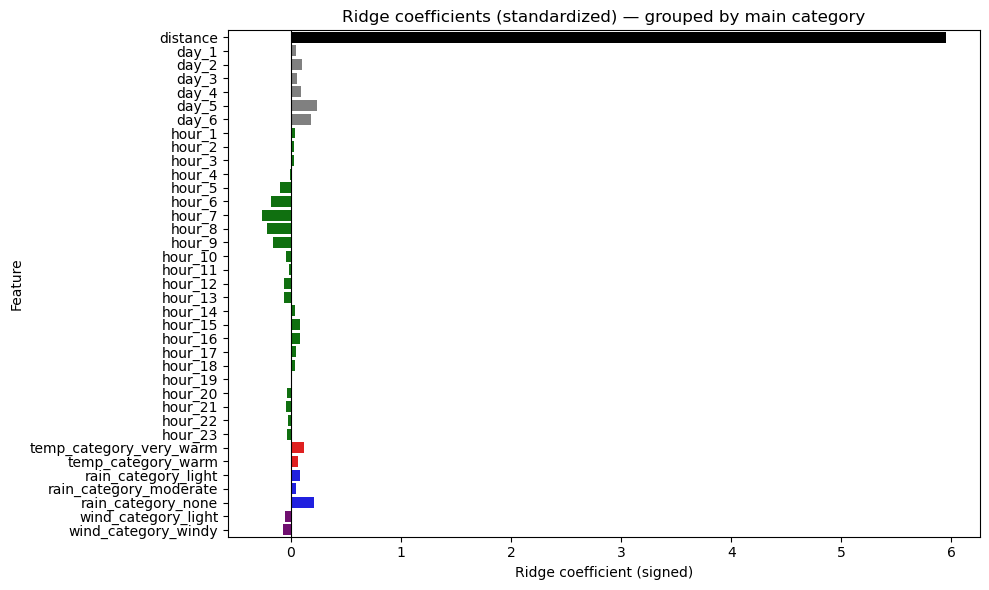

[CV] RidgeCV pipeline R²: mean=0.7701, std=0.0050
[CV] RidgeCV pipeline MSE: mean=10.7151, std=0.8867
[DONE] Optimized Ridge Regression analysis complete.


In [94]:
# --- Ridge Regression (standardized) workflow (optimized for speed & memory)
# Standardizes df_model2_dummies features, performs RidgeCV to select alpha,
# fits the final Ridge model and displays/plots the coefficients grouped by category.

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

df_at_use = df_model2_dummies.copy()
df_coeffs = df_model2_coeffs.copy()

# 1) Prepare X and y
y = df_at_use['travel_time']
X = df_at_use.drop(columns=['datetime_1h', 'travel_time'])

print(f"[INFO] X shape: {X.shape}, y shape: {y.shape}")

# 2) Define a pipeline with StandardScaler and RidgeCV
alphas = np.logspace(-5, 1, 10)
selected_cv = 5
ridgecv_pipe = make_pipeline(
    StandardScaler(),
    RidgeCV(alphas=alphas, cv=selected_cv, scoring='neg_mean_squared_error')
)

print(f"[STEP] Running RidgeCV with {selected_cv}-fold CV to select best alpha...")
ridgecv_pipe.fit(X, y)

# retrieve the trained RidgeCV estimator inside the pipeline
ridgecv = ridgecv_pipe.named_steps['ridgecv']
best_alpha = ridgecv.alpha_
print(f"[RESULT] Best alpha found by RidgeCV: {best_alpha}")

# 3) Extract coefficients (standardized scale) and build a lightweight DataFrame
coeffs = pd.Series(ridgecv.coef_, index=X.columns, name='Ridge_Coefficient')
df_ridge_coeffs = coeffs.to_frame()
# (deleted creation of abs_coef to save memory as requested)

display(df_ridge_coeffs.head(20))

# 4) OLS coefficients: prefer using the last model's coefficients if available
if 'df_coeffs' in globals():
    try:
        ols_coeffs = pd.Series(df_coeffs['Coefficient'].values, index=df_coeffs.index, name='OLS_Coefficient')
        # if df_model2_coeffs contains only the features we need, reindex to X.columns
        if set(ols_coeffs.index) >= set(X.columns):
            ols_coeffs = ols_coeffs.reindex(X.columns)
        else:
            # fallback: compute OLS on standardized X
            lr = LinearRegression()
            lr.fit(StandardScaler().fit_transform(X), y)
            ols_coeffs = pd.Series(lr.coef_, index=X.columns, name='OLS_Coefficient')
    except Exception:
        lr = LinearRegression()
        lr.fit(StandardScaler().fit_transform(X), y)
        ols_coeffs = pd.Series(lr.coef_, index=X.columns, name='OLS_Coefficient')
else:
    # compute simple OLS on standardized features
    lr = LinearRegression()
    lr.fit(StandardScaler().fit_transform(X), y)
    ols_coeffs = pd.Series(lr.coef_, index=X.columns, name='OLS_Coefficient')

# Build compare dataframe but do not create extra large columns
df_compare = pd.concat([df_ridge_coeffs['Ridge_Coefficient'], ols_coeffs], axis=1)

print("[INFO] Example of Ridge vs OLS coefficients (first rows):")
display(df_compare.head(20))

# 5) One combined plot: uniform colors per main category and category-based sorting
# Define category ordering
category_order = [
    'intercept',
    'distance',
    'day_',
    'hour_',
    'temp_category_',
    'rain_category_',
    'wind_category_'
]

col_pos = {c: i for i, c in enumerate(X.columns)}

def category_key(name):
    for i, prefix in enumerate(category_order):
        if prefix.endswith('_'):
            if name.startswith(prefix):
                return (i, col_pos.get(name, 0))
        else:
            if name == prefix:
                return (i, col_pos.get(name, 0))
    # others last
    return (len(category_order), col_pos.get(name, 0))

sorted_cols = sorted(list(X.columns), key=category_key)
# reorder df_ridge_coeffs accordingly
df_ridge_coeffs = df_ridge_coeffs.reindex(sorted_cols)

# uniform colors per main category
palette_map = {
    'intercept': 'cyan',
    'distance': 'black',
    'day_': 'gray',
    'hour_': 'green',
    'temp_category_': 'red',
    'rain_category_': 'blue',
    'wind_category_': 'purple'
}

colors = []
for name in df_ridge_coeffs.index:
    assigned = 'gray'
    for prefix, col in zip(category_order, [None]*len(category_order)):
        if prefix.endswith('_') and name.startswith(prefix):
            assigned = palette_map.get(prefix, 'gray')
            break
        elif name == prefix:
            assigned = palette_map.get(prefix, 'gray')
            break
    colors.append(assigned)

# Plot
plt.figure(figsize=(10, max(6, len(sorted_cols)*0.08)))
sns.barplot(x=df_ridge_coeffs['Ridge_Coefficient'].values, y=df_ridge_coeffs.index, palette=colors, orient='h')
plt.title('Ridge coefficients (standardized) — grouped by main category')
plt.xlabel('Ridge coefficient (signed)')
plt.ylabel('Feature')
plt.axvline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()

# 6) Cross-validated metrics
cv_scores_r2 = cross_val_score(ridgecv_pipe, X, y, cv=selected_cv, scoring='r2')
cv_scores_mse = cross_val_score(ridgecv_pipe, X, y, cv=selected_cv, scoring='neg_mean_squared_error')
print(f"[CV] RidgeCV pipeline R²: mean={cv_scores_r2.mean():.4f}, std={cv_scores_r2.std():.4f}")
print(f"[CV] RidgeCV pipeline MSE: mean={-cv_scores_mse.mean():.4f}, std={cv_scores_mse.std():.4f}")

print('[DONE] Optimized Ridge Regression analysis complete.')


#### b/ Decision Tree (first approach using top features)

Below is a first Decision Tree built on the 15 most important features according to the Ridge coefficients (on standardized features). This helps interpret interactions and non-linear effects.

[INFO] Selected top 15 features for Decision Tree:
 ['distance', 'hour_7', 'day_5', 'hour_8', 'rain_category_none', 'day_6', 'hour_6', 'hour_9', 'temp_category_very_warm', 'day_2', 'hour_5', 'day_4', 'hour_15', 'hour_16', 'rain_category_light']
Decision Tree R² on test: 0.7723
Decision Tree MSE on test: 10.5735


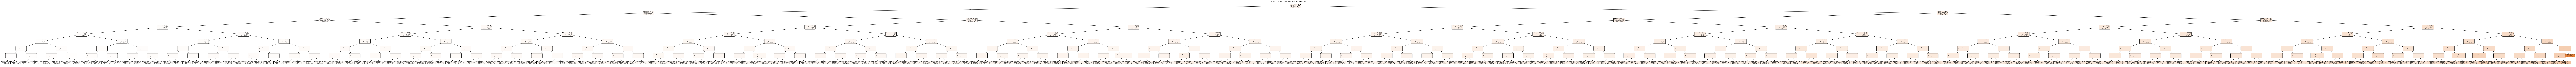

In [95]:
# Decision Tree using top 15 Ridge features
from sklearn.tree import DecisionTreeRegressor, plot_tree

# Select top 15 features by absolute Ridge coefficient (compute abs temporarily)
abs_ridge = df_ridge_coeffs['Ridge_Coefficient'].abs()
top_n = 15
selected_features = list(abs_ridge.sort_values(ascending=False).head(top_n).index)
print(f"[INFO] Selected top {top_n} features for Decision Tree:\n", selected_features)

# Prepare data
X_dt = X[selected_features].copy()
# Use the existing my_train_test_split function
X_train_dt, X_test_dt, y_train_dt, y_test_dt = my_train_test_split(X_dt, y)

# Fit a shallow decision tree for interpretability
dt = DecisionTreeRegressor(max_depth=8, random_state=0)
dt.fit(X_train_dt, y_train_dt)

# Evaluate
from sklearn.metrics import r2_score, mean_squared_error
pred_dt = dt.predict(X_test_dt)
print(f"Decision Tree R² on test: {r2_score(y_test_dt, pred_dt):.4f}")
print(f"Decision Tree MSE on test: {mean_squared_error(y_test_dt, pred_dt):.4f}")

# Plot the tree
plt.figure(figsize=(400, 10))
plot_tree(dt, feature_names=selected_features, filled=True, fontsize=8, rounded=True)
plt.title('Decision Tree (max_depth=4) on top Ridge features')
plt.show()

# Short note: decision trees can reveal interactions and thresholds; use them as exploratory tools.


#### c/ Decision Tree (using all features)

Below is a Decision Tree built on **all features** from `df_model2_dummies`. This provides a more comprehensive view of interactions and thresholds across the entire feature set.

[INFO] Decision Tree using all 37 features
Decision Tree R² on test: 0.7722
Decision Tree MSE on test: 10.5777


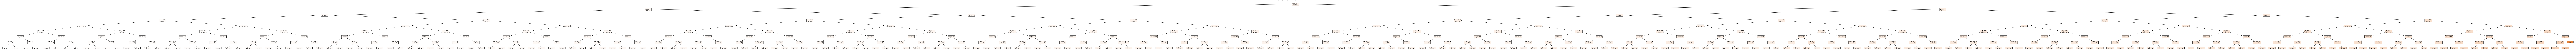

[INFO] Top 15 features by Decision Tree importance:


distance                   0.993711
hour_7                     0.002265
hour_8                     0.001964
day_5                      0.001347
hour_9                     0.000194
day_6                      0.000174
hour_6                     0.000111
hour_16                    0.000078
rain_category_none         0.000055
hour_15                    0.000032
hour_14                    0.000023
wind_category_light        0.000019
hour_17                    0.000015
hour_18                    0.000010
temp_category_very_warm    0.000001
Name: Importance, dtype: float64

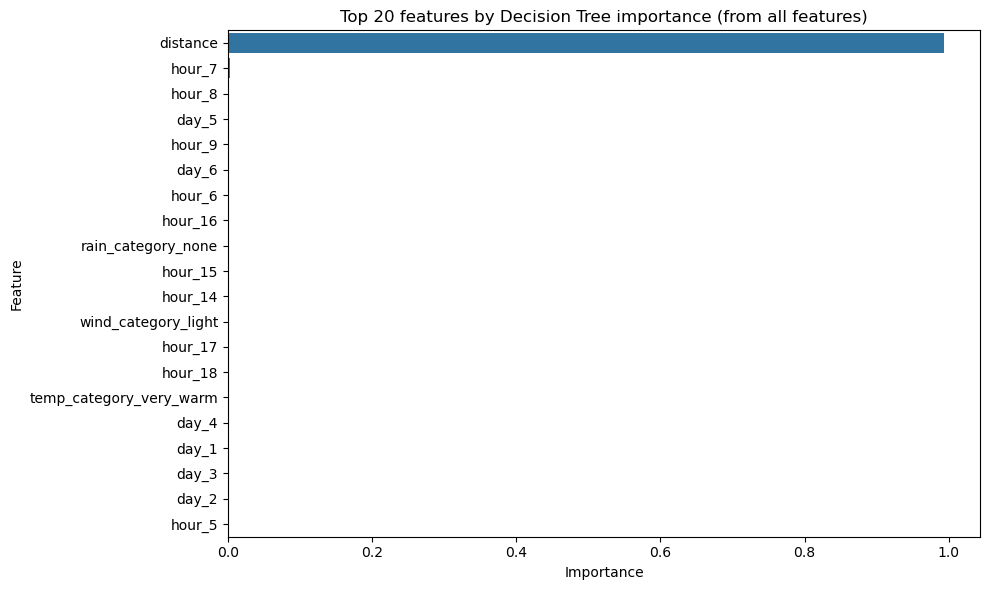

[DONE] Decision Tree (all features) analysis complete.


In [96]:
# Decision Tree using ALL features from df_model2_dummies
from sklearn.tree import DecisionTreeRegressor, plot_tree

# Use all features
X_dt_all = X.copy()
# Use the existing my_train_test_split function
X_train_dt_all, X_test_dt_all, y_train_dt_all, y_test_dt_all = my_train_test_split(X_dt_all, y)

print(f"[INFO] Decision Tree using all {len(X.columns)} features")

# Fit a shallow decision tree for interpretability (max_depth=4 for readability)
dt_all = DecisionTreeRegressor(max_depth=8, random_state=0)
dt_all.fit(X_train_dt_all, y_train_dt_all)

# Evaluate
from sklearn.metrics import r2_score, mean_squared_error
pred_dt_all = dt_all.predict(X_test_dt_all)
print(f"Decision Tree R² on test: {r2_score(y_test_dt_all, pred_dt_all):.4f}")
print(f"Decision Tree MSE on test: {mean_squared_error(y_test_dt_all, pred_dt_all):.4f}")

# Plot the tree
plt.figure(figsize=(500, 10))
plot_tree(dt_all, feature_names=list(X.columns), filled=True, fontsize=8, rounded=True)
plt.title('Decision Tree (max_depth=4) on all features')
plt.tight_layout()
plt.show()

# Feature importance
feature_importance = pd.Series(dt_all.feature_importances_, index=X.columns, name='Importance')
feature_importance = feature_importance.sort_values(ascending=False)
print("[INFO] Top 15 features by Decision Tree importance:")
display(feature_importance.head(15))

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance.head(20).values, y=feature_importance.head(20).index, orient='h')
plt.title('Top 20 features by Decision Tree importance (from all features)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print('[DONE] Decision Tree (all features) analysis complete.')
